# Proyecto Enseña Chile – Análisis de Reclutamiento

Este notebook tiene como objetivo analizar datos históricos de postulantes a Enseña Chile y cruzarlos con información externa del MINEDUC para identificar universidades y carreras con mayor concentración de candidatos idóneos, ayudando así a mejorar el proceso de reclutamiento.

## Objetivos específicos:
1. Caracterizar históricamente a postulantes y seleccionados.
2. Analizar la relación universidad-carrera-selección.
3. Identificar universidades y carreras prioritarias.
4. Proponer una categorización en niveles de prioridad.

# Entrega Inicial del Repositorio

## Contexto y motivación

Enseña Chile es una fundación que busca atraer profesionales talentosos al mundo educativo para
generar un impacto real en las comunidades escolares más vulnerables del país.

No obstante, sus procesos de postulación enfrentan desafíos importantes: la tasa de aceptación suele
ser baja y los perfiles de quienes postulan parecen ser bastante heterogéneos.

Este proyecto apunta a utilizar los datos históricos de postulaciones de Enseña Chile, junto con
información universitaria disponible en fuentes públicas como el MINEDUC, para detectar patrones,
brechas y oportunidades de mejora en el reclutamiento y selección del programa. La idea es elaborar
recomendaciones estratégicas que ayuden a la Fundación a focalizar mejor sus esfuerzos, diversificar
el perfil de candidatos y aumentar la probabilidad de éxito en las postulaciones.

La audiencia principal de este trabajo está compuesta por el equipo de gestión de Enseña Chile, aunque
también busca ser un aporte para investigadores y responsables de políticas educativas interesados en
comprender con mayor claridad cómo se distribuye el talento docente potencial en el país.

## Preguntas objetivo

¿Qué características académicas y sociodemográficas se correlacionan con un mayor éxito en el proceso de selección de Enseña Chile?

¿Existen universidades o carreras que presenten consistentemente una mayor proporción de postulantes aceptados?

¿Qué regiones del país presentan menor participación o tasa de éxito en postulaciones?

¿Es posible construir un modelo predictivo que estime la probabilidad de éxito de un postulante en función de sus características iniciales?

¿Cómo se pueden utilizar estos hallazgos para focalizar los esfuerzos de reclutamiento y reducir posibles sesgos hacia ciertas instituciones de elite?

## Datos

Datos internos de Enseña Chile:
- Registros históricos de postulaciones:
  
    - Columnas `Generación`/`Año pech`: Año de la generación donde seleccionado iniciaría su primer año de colegio
    - Columnas `# Proceso`/`Proceso`: Procesos de postulación según fechas que se deciden cada año. De 1 a 3 anuales
     - Columna `Resumen Estado Postulación`: Si está en proceso, fuera del proceso o seleccionado.
    - Columna `Estado de la Postulación`: Depende de la etapa en que se encuentra
    - Siglas usadas en celdas:
        - DE: Día de Entrevista (Etapa de selección antigua)
        - PR: Primera Revisión (Formulario: filtro 1)
        - ET: Entrevista Telefónica (filtro 1.1)
        - EG: Entrevista Grupal (filtro 2)
        - EP: Entrevista Personal (filtro 3)








Datos externos (fuentes públicas):
- Distribución de estudiantes universitarios por institución, región y carrera.
- Información de equidad y brechas (ej. género, tipo de institución).

Datos DEMRE:
- Puntajes PAES de matrícula, por año, provistos por datos abiertos del Departamento de
Medición, Evaluación y Registro Educacional de la Universidad de Chile.



## Análisis exploratorio de los datos

# 1 Configuracion inicial

## 1.1 Bibliotecas

In [153]:
!pip install lxml

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [154]:
!pip install python-magic

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [155]:
!pip install python-magic-bin

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [156]:
!pip install ftfy

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


Este notebook se desarrolló en Google Colab, donde el almacenamiento de archivos es solo temporal, por tanto, para que no tuvieramos que subir los archivos necesarios cada vez que quisieramos correr el notebook, usamos la libreria `gdown` para automatizar la descarga de archivos desde nuestra carpeta del proyecto en Google Drive.

In [157]:
!pip install gdown

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\crist\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [158]:
import magic
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
import json
from datetime import datetime
from ftfy import fix_text
import unicodedata
import gdown

In [159]:
# Configuraciones de visualizacion
pd.set_option('display.max_columns', None)
sns.set_theme(style="whitegrid")

## 1.2 Descarga de archivos

In [160]:
url_drive = "https://drive.google.com/uc?id="

In [161]:
por_descargar = {'1hrwPpacqX8hg41KQG_7Yr-jhVPmYCSLr': Path("datasets/Postulaciones historicas ECh ORIGINAL.xls"),
                 '1apwRW4Evdr1vuPeOawA_oIef1_ay_Hco': Path("datasets/Postulaciones historicas ECh.csv"),
                 '1hePtnwicwz_fv-hwF7S_3bRIwvb7gfC3': Path("imagenes/ultimas filas.png"),
                 '12SGs7YOE4uzXqX3MpwZDUpk_IviKAvkI': Path("mapeos/carreras.json")}
                 #'1NV_TQSis9q7Btoaa7Wmvgc9XCWQ4Xtaz': Path("datasets/titulados.csv")

In [162]:
"""for id_archivo, ruta_archivo in por_descargar.items():
    # Obtenemos el directorio padre
    directorio_padre = ruta_archivo.parent 
    
    # Creamos el directorio
    directorio_padre.mkdir(parents=True, exist_ok=True)
    
    # Abrir en modo binario
    with ruta_archivo.open("wb") as archivo:
        print(f'Descargando "{ruta_archivo.name}"...')
        gdown.download(url_drive + id_archivo, archivo, quiet=True)
        print('Descarga completa\n')"""
# Solo fue mientras trabajabamos en colab, en el repositorio no es necesaria esta celda

'for id_archivo, ruta_archivo in por_descargar.items():\n    # Obtenemos el directorio padre\n    directorio_padre = ruta_archivo.parent \n\n    # Creamos el directorio\n    directorio_padre.mkdir(parents=True, exist_ok=True)\n\n    # Abrir en modo binario\n    with ruta_archivo.open("wb") as archivo:\n        print(f\'Descargando "{ruta_archivo.name}"...\')\n        gdown.download(url_drive + id_archivo, archivo, quiet=True)\n        print(\'Descarga completa\n\')'

# 2 Carga y Exploración Inicial de los Datos

## 2.1 Postulantes

### 2.1.1 Crear DataFrame

El archivo que nos entregaron tiene extensión `.xls`, formato usado desde Excel 97 a Excel 2003, predecesor del actual `.xlsx` introducido en Excel 2007. <br>
Intentamos cargarlo con `read_excel()`

In [163]:
ruta_xls = Path("datasets/Postulaciones historicas ECh ORIGINAL.xls")
try:
    with open(ruta_xls) as archivo:
        df_postulantes = pd.read_excel(archivo)
except Exception as e:
    print(f"{type(e).__name__}: {e}")

ValueError: Excel file format cannot be determined, you must specify an engine manually.


inspeccionamos el tipo de archivo

In [164]:
tipo_archivo = magic.from_file(str(ruta_xls))
print(tipo_archivo)

HTML document, ISO-8859 text, with very long lines, with CRLF, LF line terminators


intentamos cargar como html

In [165]:
df_postulantes = pd.read_html(ruta_xls)

intentamos mostrar las primeras filas

In [166]:
try:
    df_postulantes.head()
except Exception as e:
    print(f"{type(e).__name__}: {e}")

AttributeError: 'list' object has no attribute 'head'


investigando nos damos cuenta de que `read_html()` retorna una lista de dataframes. <br>
imprimimos cuantos hay

In [167]:
lista_html = df_postulantes
len(lista_html)

1

mostramos el que contiene

In [168]:
df_postulantes = lista_html[0]
display(df_postulantes.head())
display(df_postulantes.tail())

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2021.0,NaN,NaN,3.0,37.0,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),NaN,Fonoaudiología,NaN,NaN,NaN
1,2021.0,NaN,NaN,1.0,29.0,Seleccionado,Acepta compromiso peCh,Macarena Alejandra,Buschmann Cambiaso,Pontificia U. Católica de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
2,2020.0,NaN,NaN,1.0,31.0,Seleccionado,Acepta compromiso peCh,Martín,Jaeger,U. de Chile,NaN,Economía,NaN,NaN,NaN
3,2021.0,NaN,NaN,1.0,30.0,Seleccionado,Acepta compromiso peCh,María Ignacia,Gibson,U. de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
4,2021.0,NaN,NaN,1.0,35.0,Seleccionado,Acepta compromiso peCh,Evelyn,Espinosa,U. Andrés Bello (Santiago),NaN,Bioquímica,NaN,NaN,NaN


,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71623,2025.0,2025.0,NaN,10.0,35.0,Seleccionado,Acepta compromiso peCh,Moisés Ignacio,Álvarez Riquelme,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,Ingeniería Civil otra mención,NaN,NaN
71624,2030.0,2030.0,NaN,1.0,28.0,Seleccionado,Aceptado a EG,Valentina,Test,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,NaN,NaN,NaN
71625,2030.0,2030.0,NaN,1.0,NaN,Seleccionado,Aceptado en DE,Jennifer,Test,NaN,NaN,NaN,NaN,NaN,NaN
71626,2030.0,2030.0,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Pol...,NaN,NaN,NaN
71627,2030.0,2030.0,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN


Captura de pantalla de las ultimas filas del dataset en Excel:

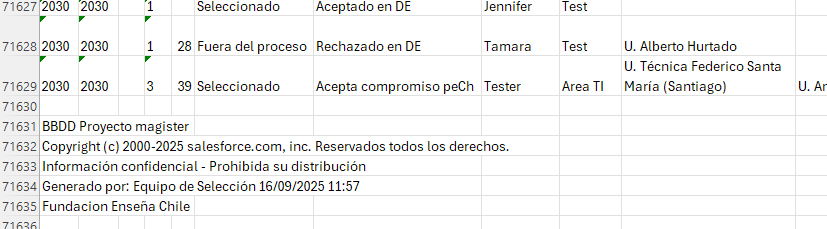

In [169]:
Image(Path("imagenes/ultimas filas.png"))

 Comparando la cola con lo que muestra Excel, a nuestro dataframe le faltan las ultimas 6 filas. <br>
 A pesar de que las filas extraviadas no son relevantes para nuestro analisis, el formato del archivo no nos da confianza. Puede que hayan mas celdas que se perdieron durante la carga. Para maximizar la compatibilidad optamos por exportar el archivo a un `.csv` con Excel y lo cargamos con `read_csv()`

In [170]:
ruta_csv = Path("datasets/Postulaciones historicas ECh.csv")
df_postulantes = pd.read_csv(ruta_csv, low_memory=False)
# low_memory=False para que pandas infiera los tipos de datos despues de leer todo el archivo
# y asi no terminar con columnas con multiples tipos de datos

el `DtypeWarning` nos avisa que en la columna 0 hay varios tipos de datos, por tanto `pandas` dejó todas esas entradas como tipo `object`

In [171]:
with pd.option_context('display.max_colwidth', None):
    display(df_postulantes.tail(8))

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71626,2030,2030.0,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Política,NaN,NaN,NaN
71627,2030,2030.0,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN
71628,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71629,BBDD Proyecto magister,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71630,"Copyright (c) 2000-2025 salesforce.com, inc. Reservados todos los derechos.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71631,Información confidencial - Prohibida su distribución,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71632,Generado por: Equipo de Selección 16/09/2025 11:57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
71633,Fundacion Enseña Chile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Ahora sí se muestran las observaciones del final. Además, contando las filas desde 0 (en vez de 1) y no considerando el encabezado, las dimensiones del dataframe son iguales a las de la tabla mostrada en Excel.

### 2.1.2 Primer vistazo

Resumen de las columnas

In [172]:
df_postulantes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71634 entries, 0 to 71633
Data columns (total 15 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Año Pech                    67994 non-null  object 
 1   Generación                  67967 non-null  float64
 2   # Proceso                   824 non-null    float64
 3   Proceso                     67559 non-null  float64
 4   Edad                        71094 non-null  float64
 5   Resumen Estado Postulación  71627 non-null  object 
 6   Estado de la Postulación    71628 non-null  object 
 7   Nombre                      71624 non-null  object 
 8   Apellidos                   71628 non-null  object 
 9   Universidad                 40966 non-null  object 
 10  Universidad (old)           31093 non-null  object 
 11  Carrera                     67930 non-null  object 
 12  Carrera.1                   3735 non-null   object 
 13  Otra Carrera                912

Cantidad de datos nulos en el Dataframe por columna

In [173]:
df_postulantes.isnull().sum()

Año Pech                       3640
Generación                     3667
# Proceso                     70810
Proceso                        4075
Edad                            540
Resumen Estado Postulación        7
Estado de la Postulación          6
Nombre                           10
Apellidos                         6
Universidad                   30668
Universidad (old)             40541
Carrera                        3704
Carrera.1                     67899
Otra Carrera                  70722
Otra carrera, ¿Cuál?          70913
dtype: int64

mostrar estadisticas por columna

In [174]:
df_postulantes.describe(include='all')

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
count,67994,67967.000000,824.000000,67559.000000,71094.000000,71627,71628,71624,71628,40966,31093,67930,3735,912,721
unique,23,NaN,NaN,NaN,NaN,4,32,28397,55064,94,77,245,131,726,656
top,2023,NaN,NaN,NaN,NaN,Incompleta,Postulación incompleta,Daniela,Muñoz,Otra,Otra,Otra,Otra,Ingeniero en prevención de riesgos,Derecho
freq,9909,NaN,NaN,NaN,NaN,42687,42688,522,64,4963,2911,4162,220,13,5
mean,NaN,2018.166581,1.188107,2.115913,38.225842,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.374980,0.391035,1.129545,9.643208,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,2009.000000,1.000000,0.000000,-950.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2015.000000,1.000000,1.000000,33.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2018.000000,1.000000,2.000000,37.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2021.000000,1.000000,3.000000,41.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## 2.2 Datos Titulados 2024 (Entrega 2)

In [175]:
def filtrar_y_agrupar_carreras(csv_file: str, min_titulados: int = 50, output_filename: str = '') -> pd.DataFrame:
    """
    Filtra y agrupa carreras de un DataFrame de titulados de educación superior.

    Args:
        csv_file (str): La ruta del archivo CSV a procesar.
        min_titulados (int): El número mínimo de titulados para que una carrera agrupada se mantenga en el resultado.

    Returns:
        pd.DataFrame: DataFrame filtrado y con la columna 'carrera_agrupada'.
    """

    try:
        df = pd.read_csv(csv_file, sep=';')
    except FileNotFoundError:
        print(f"Error: El archivo '{csv_file}' no fue encontrado.")
        return pd.DataFrame()
    except Exception as e:
        print(f"{type(e).__name__}: {e}")
        return pd.DataFrame()

    df_busqueda = df[['cat_periodo', 'nomb_carrera', 'nivel_carrera_1',
                      'nombre_titulo_obtenido', 'nomb_inst', 'tipo_inst_1',
                      'region_sede', 'area_conocimiento']].copy()

    # Filtrar por tipo de institución (Universidades)
    df_busqueda = df_busqueda[df_busqueda.tipo_inst_1 == 'Universidades']

    # Filtrar por nivel de carrera
    grados_objetivo = [
        'Licenciatura No Conducente a Título',
        'Profesional Con Licenciatura',
        'Profesional Sin Licenciatura'
    ]
    df_busqueda = df_busqueda[df_busqueda.nivel_carrera_1.isin(grados_objetivo)]

    # Filtrar por área de conocimiento (excluyendo Derecho, Salud, etc.)
    areas_objetivo = [
        'Tecnología',
        'Humanidades',
        'Educación',
        'Ciencias Básicas',
        'Agropecuaria',
        'Administración y Comercio'
    ]
    df_busqueda = df_busqueda[df_busqueda.area_conocimiento.isin(areas_objetivo)]

    # Aseguramos que 'nomb_carrera' esté en mayúsculas para la normalización
    df_busqueda['nomb_carrera'] = df_busqueda['nomb_carrera'].str.upper()

    # Filtrar por palabras clave de inclusión (INCLUIR)
    keywords_incluir = [
        'Periodismo', 'Letras', 'Literatura', 'Ingenieria', 'Estadistica',
        'Matematica', 'Fisica', 'Astronomia', 'Contador', 'Auditor', 'Lenguaje'
    ]
    # No es necesario upper() si ya lo hicimos antes, pero se mantiene la lógica
    regex_pattern_incluir = '|'.join(keywords_incluir).upper()

    mascara_incluir = df_busqueda.nomb_carrera.str.contains(regex_pattern_incluir, na=False)
    df_busqueda = df_busqueda[mascara_incluir].copy() # Usar copy() para evitar SettingWithCopyWarning

    # Filtrar por palabras clave de exclusión (EXCLUIR)
    keywords_excluir = [
        'BASICA', 'EDUCACION', 'TECNICO', "DEPORTE", "ACTIVIDAD", 'CREATIVA', 'INGLESAS'
    ]
    regex_pattern_excluir = '|'.join(keywords_excluir).upper()

    mascara_excluir = df_busqueda.nomb_carrera.str.contains(regex_pattern_excluir, na=False)
    df_busqueda = df_busqueda[~mascara_excluir].copy()

    # Crear la columna de 'carrera_agrupada'
    df_busqueda['carrera_agrupada'] = df_busqueda['nomb_carrera']

    # Agrupar carreras específicas

    # Ingeniería y Auditoría
    mascara_ingenieria = df_busqueda['nomb_carrera'].str.contains('INGENIERIA', na=False)
    mascara_auditoria = df_busqueda['nomb_carrera'].str.contains('AUDITOR', na=False)

    df_busqueda.loc[mascara_ingenieria, 'carrera_agrupada'] = 'INGENIERIA'
    df_busqueda.loc[mascara_auditoria, 'carrera_agrupada'] = 'AUDITOR'

    # Letras
    letras = [
        'LICENCIATURA EN LINGÜISTICA Y LITERATURA',
        'LETRAS HISPANICAS',
        'LICENCIATURA EN LITERATURA',
        'LICENCIATURA EN LENGUA Y LITERATURA', 'LICENCIATURA EN LETRAS MENCION LINGÜISTICA Y LITERATURA HISPANICA'
    ]
    df_busqueda.loc[df_busqueda['carrera_agrupada'].isin(letras), 'carrera_agrupada'] = 'LICENCIATURA EN LETRAS HISPANICAS'

    # Pedagogía en Matemáticas
    pedagogia_matematica = [
        'PEDAGOGIA EN MATEMATICAS Y FISICA', 'PEDAGOGIA EN MATEMATICAS Y/O LICENCIATURA EN MATEMATICAS',
        'PEDAGOGIA EN MATEMATICA', 'PEDAGOGIA EN MATEMATICAS E INFORMATICA EDUCATIVA',
        'PEDAGOGIA EN MATEMATICA Y COMPUTACION', 'PEDAGOGIA EN MATEMATICAS'
    ]
    df_busqueda.loc[df_busqueda['carrera_agrupada'].isin(pedagogia_matematica), 'carrera_agrupada'] = 'PEDAGOGIA EN MATEMATICAS'

    # Astronomía
    astronomia = [
        'LICENCIATURA EN ASTRONOMIA', 'ASTRONOMIA'
    ]
    df_busqueda.loc[df_busqueda['carrera_agrupada'].isin(astronomia), 'carrera_agrupada'] = 'ASTRONOMIA'

    # Filtrar por mínimo de titulados
    df_filtrado = df_busqueda.groupby('carrera_agrupada').filter(lambda x: len(x) >= min_titulados).copy()

    print(f"\n Conteo de Titulados por Carrera Agrupada (Mínimo {min_titulados} titulados):")

    try:
        df_filtrado.to_csv(output_filename, index=False, sep=';', encoding='utf-8')
        print(f"\n El DataFrame final ha sido guardado como: {output_filename}")
    except Exception as e:
        print(f"Error al guardar el archivo: {e}")

    return df_filtrado

In [176]:
df_resultado_2024 = filtrar_y_agrupar_carreras('Titulados_Ed_Superior_2024.csv', output_filename= 'Titulados_filtrado_2024.csv')

Error: El archivo 'Titulados_Ed_Superior_2024.csv' no fue encontrado.


Primero que nada vamos a hacer una limpieza rapida

In [177]:
df_resultado_2023 = filtrar_y_agrupar_carreras(
    'Titulados_Ed_Superior_2023.csv', output_filename= 'Titulados_filtrado_2023.csv')
df_resultado_2022 = filtrar_y_agrupar_carreras(
    'Titulados_Ed_Superior_2022.csv', output_filename= 'Titulados_filtrado_2022.csv')
df_resultado_2021 = filtrar_y_agrupar_carreras(
    'Titulados_Ed_Superior_2021.csv', output_filename= 'Titulados_filtrado_2021.csv')
df_resultado_2020 = filtrar_y_agrupar_carreras(
    'Titulados_Ed_Superior_2020.csv', output_filename= 'Titulados_filtrado_2020.csv')


Error: El archivo 'Titulados_Ed_Superior_2023.csv' no fue encontrado.
Error: El archivo 'Titulados_Ed_Superior_2022.csv' no fue encontrado.
Error: El archivo 'Titulados_Ed_Superior_2021.csv' no fue encontrado.
Error: El archivo 'Titulados_Ed_Superior_2020.csv' no fue encontrado.


Ahora utilizamos los nuevos dataframes que se subieron al drive

In [178]:
nombre_archivo = "Titulados_filtrado_2024.csv"
id_archivo = "1xKSnMC0r741IRG0C-bHM7mfrzqfQZdAY"
gdown.download(url_drive + id_archivo, nombre_archivo)

Downloading...
From: https://drive.google.com/uc?id=1xKSnMC0r741IRG0C-bHM7mfrzqfQZdAY
To: c:\Users\crist\OneDrive - Universidad Católica de Chile\Escritorio\Estudio\2° Semestre\IMT2200\IMT2200-Proyecto-Semestral\Titulados_filtrado_2024.csv
100%|██████████| 6.46M/6.46M [00:00<00:00, 10.8MB/s]


'Titulados_filtrado_2024.csv'

In [179]:
nombre_archivo = "Titulados_filtrado_2023.csv"
id_archivo = "1FIOSIxU7Io2GGt4whOQTSeGOhgLH5Y32"
gdown.download(url_drive + id_archivo, nombre_archivo)

Downloading...
From: https://drive.google.com/uc?id=1FIOSIxU7Io2GGt4whOQTSeGOhgLH5Y32
To: c:\Users\crist\OneDrive - Universidad Católica de Chile\Escritorio\Estudio\2° Semestre\IMT2200\IMT2200-Proyecto-Semestral\Titulados_filtrado_2023.csv
100%|██████████| 6.78M/6.78M [00:00<00:00, 10.8MB/s]


'Titulados_filtrado_2023.csv'

In [180]:
nombre_archivo = "Titulados_filtrado_2022.csv"
id_archivo = "16-OVpwPYKfBqiJ5fl8J7fKElRgLZHhIM"
gdown.download(url_drive + id_archivo, nombre_archivo)

Downloading...
From: https://drive.google.com/uc?id=16-OVpwPYKfBqiJ5fl8J7fKElRgLZHhIM
To: c:\Users\crist\OneDrive - Universidad Católica de Chile\Escritorio\Estudio\2° Semestre\IMT2200\IMT2200-Proyecto-Semestral\Titulados_filtrado_2022.csv
100%|██████████| 6.55M/6.55M [00:00<00:00, 11.0MB/s]


'Titulados_filtrado_2022.csv'

In [181]:
nombre_archivo = "Titulados_filtrado_2021.csv"
id_archivo = "1-ToIFK_z4CaZ0Wn1_YQJwMGPPZ3CC2Wu"
gdown.download(url_drive + id_archivo, nombre_archivo)

Downloading...
From: https://drive.google.com/uc?id=1-ToIFK_z4CaZ0Wn1_YQJwMGPPZ3CC2Wu
To: c:\Users\crist\OneDrive - Universidad Católica de Chile\Escritorio\Estudio\2° Semestre\IMT2200\IMT2200-Proyecto-Semestral\Titulados_filtrado_2021.csv
100%|██████████| 6.46M/6.46M [00:00<00:00, 10.6MB/s]


'Titulados_filtrado_2021.csv'

In [182]:
nombre_archivo = "Titulados_filtrado_2020.csv"
id_archivo = "1ZBkxOiIiGZ4NVgYw_0fO_lEIFjfFtzvD"
gdown.download(url_drive + id_archivo, nombre_archivo)

Downloading...
From: https://drive.google.com/uc?id=1ZBkxOiIiGZ4NVgYw_0fO_lEIFjfFtzvD
To: c:\Users\crist\OneDrive - Universidad Católica de Chile\Escritorio\Estudio\2° Semestre\IMT2200\IMT2200-Proyecto-Semestral\Titulados_filtrado_2020.csv
100%|██████████| 5.19M/5.19M [00:00<00:00, 10.5MB/s]


'Titulados_filtrado_2020.csv'

Los convertimos a dataframe y los unimos para poder analizar los datos correctamente

In [183]:
df_titulados_2024 = pd.read_csv('Titulados_filtrado_2024.csv', sep=';')
df_titulados_2023 = pd.read_csv('Titulados_filtrado_2023.csv', sep=';')
df_titulados_2022 = pd.read_csv('Titulados_filtrado_2022.csv', sep=';')
df_titulados_2021 = pd.read_csv('Titulados_filtrado_2021.csv', sep=';')
df_titulados_2020 = pd.read_csv('Titulados_filtrado_2020.csv', sep=';')

Hacemos unos ultimos ajustes

In [184]:
df_titulados_completo = pd.concat([df_titulados_2024, df_titulados_2023, df_titulados_2022, df_titulados_2021, df_titulados_2020])
conteo_carreras = df_titulados_completo['carrera_agrupada'].value_counts()
df_titulados_2021.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34533 entries, 0 to 34532
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   cat_periodo             34533 non-null  int64 
 1   nomb_carrera            34533 non-null  object
 2   nivel_carrera_1         34533 non-null  object
 3   nombre_titulo_obtenido  34325 non-null  object
 4   nomb_inst               34533 non-null  object
 5   tipo_inst_1             34533 non-null  object
 6   region_sede             34533 non-null  object
 7   area_conocimiento       34533 non-null  object
 8   carrera_agrupada        34533 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.4+ MB


In [185]:
ultimas_tres = conteo_carreras.tail(3).index
df_filtrado = df_titulados_completo[~df_titulados_completo['carrera_agrupada'].isin(ultimas_tres)]

Convertimos columnas a tipos correctos

In [186]:
df_titulados_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169731 entries, 0 to 27558
Data columns (total 9 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   cat_periodo             169731 non-null  int64 
 1   nomb_carrera            169731 non-null  object
 2   nivel_carrera_1         169731 non-null  object
 3   nombre_titulo_obtenido  168366 non-null  object
 4   nomb_inst               169731 non-null  object
 5   tipo_inst_1             169731 non-null  object
 6   region_sede             169731 non-null  object
 7   area_conocimiento       169731 non-null  object
 8   carrera_agrupada        169731 non-null  object
dtypes: int64(1), object(8)
memory usage: 12.9+ MB


In [187]:
df_titulados_completo.region_sede = df_titulados_completo.region_sede.astype('category')
df_titulados_completo.nivel_carrera_1 = df_titulados_completo.nivel_carrera_1.astype('category')
df_titulados_completo.area_conocimiento = df_titulados_completo.area_conocimiento.astype('category')
df_titulados_completo.carrera_agrupada = df_titulados_completo.carrera_agrupada.astype('category')

In [188]:
df_titulados_completo = df_titulados_completo.drop('tipo_inst_1', axis=1)
df_titulados_completo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 169731 entries, 0 to 27558
Data columns (total 8 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   cat_periodo             169731 non-null  int64   
 1   nomb_carrera            169731 non-null  object  
 2   nivel_carrera_1         169731 non-null  category
 3   nombre_titulo_obtenido  168366 non-null  object  
 4   nomb_inst               169731 non-null  object  
 5   region_sede             169731 non-null  category
 6   area_conocimiento       169731 non-null  category
 7   carrera_agrupada        169731 non-null  category
dtypes: category(4), int64(1), object(3)
memory usage: 7.1+ MB


# 3 Limpieza de Datos
**Objetivo:** Eliminar duplicados, manejar valores nulos, convertir tipos de datos, y estandarizar categorías.

## 3.1 Eliminar filas con observaciones

In [189]:
filas_antes = df_postulantes.shape[0]
df_postulantes = df_postulantes.iloc[:-5]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron las {eliminadas} ultimas filas.")

Se eliminaron las 5 ultimas filas.


## 3.2 Eliminar filas vacias

In [190]:
filas_antes = df_postulantes.shape[0]
filas_vacias = df_postulantes.isnull().all(axis=1)
df_postulantes = df_postulantes[~filas_vacias]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas vacias.")

Se eliminaron 1 filas vacias.


## 3.3 Eliminar duplicados

In [191]:
filas_antes = df_postulantes.shape[0]
df_postulantes.drop_duplicates(inplace=True)
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas duplicadas.")

Se eliminaron 865 filas duplicadas.


## 3.4 Columnas `Año Pech` y `Generación`

### 3.4.1 Convertir a Int64

In [192]:
df_postulantes = df_postulantes.astype({'Año Pech': 'Int64', 'Generación': 'Int64'})

### 3.4.2 Datos conflictivos

In [193]:
con_annos_distintos = (df_postulantes['Año Pech'].notna()
                     & df_postulantes['Generación'].notna()
                     & (df_postulantes['Año Pech'] != df_postulantes['Generación']))

df_postulantes[con_annos_distintos]

,Año Pech,Generación,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"


seba: no hay conflictos entre annos

### 3.4.3 unir columnas

In [194]:
df_postulantes['Año Pech'] = df_postulantes['Año Pech'].combine_first(df_postulantes['Generación'])

df_postulantes = df_postulantes.rename(columns={'Año Pech': 'Año'})

df_postulantes = df_postulantes.drop(columns='Generación')

df_postulantes.head(1)

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2021,NaN,3.0,37.0,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),NaN,Fonoaudiología,NaN,NaN,NaN


### 3.4.4 revisar datos extraños

In [195]:
print(np.sort(df_postulantes['Año'].unique().dropna()))

[2009 2010 2011 2012 2013 2014 2015 2016 2017 2018 2019 2020 2021 2022
 2023 2024 2025 2030]


#### revisar filas con anno 2030

In [196]:
con_anno_2030 = (df_postulantes['Año'] == 2030).fillna(False)
df_postulantes[con_anno_2030]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
71624,2030,NaN,1.0,28.0,Seleccionado,Aceptado a EG,Valentina,Test,U. de Santiago de Chile,NaN,Ingeniería de Ejecución (todas las especialida...,NaN,NaN,NaN
71625,2030,NaN,1.0,NaN,Seleccionado,Aceptado en DE,Jennifer,Test,NaN,NaN,NaN,NaN,NaN,NaN
71626,2030,NaN,1.0,28.0,Fuera del proceso,Rechazado en DE,Tamara,Test,U. Alberto Hurtado,NaN,Ciencia Política / Licenciatura en Ciencia Pol...,NaN,NaN,NaN
71627,2030,NaN,3.0,39.0,Seleccionado,Acepta compromiso peCh,Tester,Area TI,U. Técnica Federico Santa María (Santiago),U. Andrés Bello (Santiago),Ingeniería Civil Electrónica,NaN,asas,NaN


por los nombres se infiere que fueron filas de testeo que a los encargados de la base de datos se les olvidó quitar <br>
por tanto las eliminamos

In [197]:
filas_antes = df_postulantes.shape[0]
df_postulantes = df_postulantes[~con_anno_2030]
filas_despues = df_postulantes.shape[0]
eliminadas = filas_antes - filas_despues
print(f"Se eliminaron {eliminadas} filas")

Se eliminaron 4 filas


### 3.4.5 Restar 1 para obtener año de postulación

Citando a Sebastián I.: "En el 99% de los casos el año de postulación es 1 año antes de hacer el programa"

In [198]:
df_postulantes['Año'] -= 1

## 3.5 Columnas `# Proceso` y `Proceso`

### 3.5.1 Convertir a `Int64`

In [199]:
df_postulantes = df_postulantes.astype({'# Proceso': 'Int64', 'Proceso': 'Int64'})

### 3.5.2 datos conflictivos

In [200]:
con_procesos_distintos = (df_postulantes['# Proceso'].notna()
                          & df_postulantes['Proceso'].notna()
                          & (df_postulantes['# Proceso'] != df_postulantes['Proceso']))

df_postulantes[con_procesos_distintos]

,Año,# Proceso,Proceso,Edad,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
3148,<NA>,1,2,39.0,En proceso de selección,Aceptado a EG,Carolina Andrea,Poblete Olivera,U. del Mar,NaN,NaN,Pedagogía Básica / Educación Básica,NaN,NaN
3419,<NA>,1,2,26.0,En proceso de selección,Aceptado a EG,Andrea Rebeca del Pilar,Ruz Meyer,U. Técnica Federico Santa María (Valparaíso),NaN,NaN,Ingeniería Comercial,NaN,NaN
3423,<NA>,1,2,34.0,En proceso de selección,Aceptado a EP,Lorena,Cartes,U. de O' Higgins,NaN,NaN,Pedagogía Educación Media en Lenguaje y Comuni...,NaN,NaN
3433,<NA>,1,2,27.0,Fuera del proceso,Abandona EG,Karla Constanza,Loyola Valdés,U. de O' Higgins,NaN,NaN,Pedagogía en Inglés / Idiomas,NaN,NaN
3441,<NA>,1,2,25.0,Fuera del proceso,Abandona EG,Armando Josué Manuel,Carvajal Rivera,U. Finis Terrae,NaN,NaN,Licenciatura en Literatura / Literatura / Letras,NaN,NaN
3461,<NA>,1,2,33.0,En proceso de selección,Aceptado a EP,Ángela Patricia,Martínez Sanchez,Otra,NaN,NaN,Pedagogía Básica / Educación Básica,NaN,Licenciatura en educación básica con énfasis e...
3474,<NA>,1,2,32.0,En proceso de selección,Aceptado a EG,Sebastian Esteban,Hinojosa,U. Diego Portales,NaN,NaN,Historia / Licenciatura en Historia,NaN,NaN
3484,<NA>,1,2,36.0,Fuera del proceso,Abandona EG,Cristian Andrés,Rodríguez Pinto,U. Santo Tomás (Santiago),NaN,NaN,Periodismo / Comunicación Social,NaN,NaN
3485,<NA>,1,2,28.0,En proceso de selección,Aceptado a EG,Jose,Guillen,U. Adolfo Ibáñez (Santiago),NaN,NaN,Ingeniería Comercial,NaN,NaN
3497,<NA>,1,2,26.0,En proceso de selección,Aceptado a EG,Claudia Antonia,Vielma Cid,U. de Chile,NaN,NaN,Administración Pública,NaN,NaN


### 3.5.3 revisar datos extrannos

In [201]:
for col in ('# Proceso', 'Proceso'):
    display(df_postulantes[col].value_counts().sort_index().to_frame().T)

# Proceso,1,2
count,666,155


Proceso,0,1,2,3,4,5,9,10,11
count,6,23484,21526,15446,3674,2415,42,53,62


## 3.6 Columna `Edad`

### 3.6.1 Convertir a `Int64` y renombar a `Edad actual`

In [202]:
df_postulantes = df_postulantes.astype({'Edad': 'Int64'})
df_postulantes = df_postulantes.rename(columns={'Edad': 'Edad actual'})

### 3.6.2 Calcular edad al postular

In [203]:
# creacion del excel fue '2025-09-16 11:57' lo simplifcamos como 2025.7 para nuestros calculos
edad_con_decimales = df_postulantes['Edad actual'] - (2025.7 - df_postulantes['Año'])
# ACLARACION: si la persona tenia la celda `Año` vacia, su edad tambien quedara vacia

# Truncar el resultado e insertar en el df
df_postulantes.insert(loc=3, column='Edad', value=edad_con_decimales.astype('Int64'))


In [204]:
df_postulantes.head()

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2020,<NA>,3,31,37,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),NaN,Fonoaudiología,NaN,NaN,NaN
1,2020,<NA>,1,23,29,Seleccionado,Acepta compromiso peCh,Macarena Alejandra,Buschmann Cambiaso,Pontificia U. Católica de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
2,2019,<NA>,1,24,31,Seleccionado,Acepta compromiso peCh,Martín,Jaeger,U. de Chile,NaN,Economía,NaN,NaN,NaN
3,2020,<NA>,1,24,30,Seleccionado,Acepta compromiso peCh,María Ignacia,Gibson,U. de Chile,NaN,Ingeniería Comercial,NaN,NaN,NaN
4,2020,<NA>,1,29,35,Seleccionado,Acepta compromiso peCh,Evelyn,Espinosa,U. Andrés Bello (Santiago),NaN,Bioquímica,NaN,NaN,NaN


### 3.6.2 mostrar valores unicos

In [205]:
print(np.sort(df_postulantes['Edad'].unique()))

[-953. -940.  -47.  -46.  -44.  -42.  -40.  -39.  -37.  -35.  -34.  -32.
  -31.  -30.  -29.  -27.  -22.  -16.   -6.   -5.   -3.   -2.   -1.    0.
    1.    2.    9.   12.   13.   14.   15.   16.   17.   18.   19.   20.
   21.   22.   23.   24.   25.   26.   27.   28.   29.   30.   31.   32.
   33.   34.   35.   36.   37.   38.   39.   40.   41.   42.   43.   44.
   45.   46.   47.   48.   49.   50.   51.   52.   53.   54.   55.   56.
   57.   58.   59.   60.   61.   62.   63.   64.   65.   66.   67.   68.
   69.   70.   71.   72.   73.   74.   75.   76.   77.   78.   98.  112.
  113.  123.  127.   nan]


## 3.7 Columna `Nombre`

### 3.7.1 Revisar si hay personas sin nombre

In [206]:
sin_nombre = df_postulantes["Nombre"].isnull()
df_postulantes[sin_nombre]

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
5037,2012,<NA>,2,34,48,Incompleta,Postulación incompleta,NaN,Aguayo Mesias,NaN,U. Tecnológica de Chile (INACAP),Traducción / Intérprete,NaN,NaN,NaN
5372,2012,<NA>,<NA>,24,38,Incompleta,Postulación incompleta,NaN,Ramírez Donaire,NaN,Otra,Arte Dramático / Actuación / Teatro,NaN,NaN,NaN
30059,2016,<NA>,3,23,33,Incompleta,Postulación incompleta,NaN,guzmán ortega,NaN,U. del Bío Bío,Pedagogía Educación Media en Historia / Cienci...,NaN,NaN,NaN
33386,2016,<NA>,2,27,37,Fuera del proceso,Rechazado en PR,NaN,santana villa,NaN,U. de La Frontera,Tecnología Médica,NaN,NaN,NaN


no parecen redundantes

## 3.8 Columna `Universidad` y `Universidad (old)`

### 3.8.1 Datos conflictivos

In [207]:
con_ues_distintas = (df_postulantes['Universidad'].notna()
                     & df_postulantes['Universidad (old)'].notna()
                     & (df_postulantes['Universidad'] != df_postulantes['Universidad (old)']))

display(df_postulantes[con_ues_distintas].sort_values("Universidad"))

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Universidad (old),Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
34780,2017,<NA>,11,23,32,Seleccionado,Acepta compromiso peCh,Claudia Patricia,Millafilo Antilef,Pontificia U. Católica de Chile,U. Católica de la Santísima Concepción,Pedagogía en Inglés,NaN,NaN,NaN
28454,2016,<NA>,3,24,34,Seleccionado,Acepta compromiso peCh,Paulina Andrea,Hinojosa Alarcón,Sin información,Pontificia U. Católica de Valparaíso,Sin información,NaN,NaN,NaN
3708,2009,<NA>,<NA>,<NA>,<NA>,Seleccionado,Acepta compromiso peCh,Víctor,Ruiz,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Filosofía,NaN,NaN,NaN
14959,2013,<NA>,3,23,36,Seleccionado,Acepta compromiso peCh,Javiera,García García,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Periodismo / Comunicación Social,NaN,NaN,NaN
9976,2013,<NA>,1,23,36,Seleccionado,Acepta compromiso peCh,Camila Del Rosario,López De La Barrera,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial,NaN,NaN,NaN
15364,2014,<NA>,1,23,35,Seleccionado,Acepta compromiso peCh,Beatriz,Lyng Errázuriz,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial/Administración/ Contabilidad,NaN,NaN,NaN
6317,2012,<NA>,<NA>,23,37,Seleccionado,Acepta compromiso peCh,Macarena Loreto,Salvo Cruces,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Periodismo / Comunicación Social,NaN,NaN,NaN
6174,2012,<NA>,<NA>,22,36,Seleccionado,Acepta compromiso peCh,TAIRA SOFÍA,CORREA SIRVENT,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Ingeniería Comercial,NaN,NaN,NaN
3709,2009,<NA>,<NA>,24,41,Seleccionado,Acepta compromiso peCh,Jimena Manola Lucia,Saavedra Fernández,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Pedagogía Educación Media en Historia / Cienci...,NaN,NaN,NaN
8877,2012,<NA>,2,21,35,En proceso de selección,Sin revisar,consuelo,leyton terrazas,U. Adolfo Ibáñez (Viña del Mar),U. Adolfo Ibáñez (Santiago),Historia / Licenciatura en Historia,NaN,NaN,NaN


### 3.8.2 Unir columnas

In [208]:
df_postulantes['Universidad'] = df_postulantes['Universidad (old)'].combine_first(df_postulantes['Universidad'])

df_postulantes = df_postulantes.drop(columns='Universidad (old)')

df_postulantes.head(1)

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
0,2020,<NA>,3,31,37,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),Fonoaudiología,NaN,NaN,NaN


### 3.8.3 estandarizar nombres universidades

Para poder explorar mejor todas las entradas para universidad que hay en la database, exportamos a json

In [209]:
universidades = df_postulantes['Universidad'].sort_values().unique().tolist()

#crear carpeta
Path('por mapear').mkdir(parents=True, exist_ok=True)
ruta_archivo = Path('por mapear/universidades.json')

with open(ruta_archivo, 'w', encoding='utf-8') as file:
    json.dump(universidades, file, ensure_ascii=False, indent=2)

In [210]:
universidades_estandarizadas = {
    "U. Arcis": "U. de Arte y Ciencias Sociales - ARCIS",
    "U. de Arte y Ciencias Sociales - ARCIS": "U. de Arte y Ciencias Sociales - ARCIS",
    "U. Tecnológica de Chile (INACAP)": "U. Tecnológica de Chile - INACAP",
    "U. Tecnológica de Chile - INACAP": "U. Tecnológica de Chile - INACAP",
    "U. de Ciencias de la Informática": "U. de Ciencias de la Informática - UCINF",
    "U. de Ciencias de la Informática - UCINF": "U. de Ciencias de la Informática - UCINF",
    "U. Metropolitana de Ciencias de la Educación": "U. Metropolitana de Ciencias de la Educación - UMCE",
    "U. Metropolitana de Ciencias de la Educación - UMCE": "U. Metropolitana de Ciencias de la Educación - UMCE",
    "U. UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "U. de Artes, Ciencias y Comunicación - UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "UNIACC": "U. de Artes, Ciencias y Comunicación - UNIACC",
    "U. Tecnológica Metropolitana": "U. Tecnológica Metropolitana - UTEM",
    "U. Tecnológica Metropolitana - UTEM": "U. Tecnológica Metropolitana - UTEM",
    "U. Tecnológica Metropolitana UTEM": "U. Tecnológica Metropolitana - UTEM",
    "Duoc UC": "Duoc UC",
    "DuocUC": "Duoc UC",
    "Escuela Moderna de Música": "Escuela Moderna de Música y Danza",
    "Escuela Moderna de Música y Danza": "Escuela Moderna de Música y Danza",
    "U. Austral": "U. Austral de Chile",
    "U. Austral de Chile": "U. Austral de Chile",
    "U. Central": "U. Central de Chile",
    "U. Central de Chile": "U. Central de Chile",
    "U. de Playa Ancha": "U. de Playa Ancha de Ciencias de la Educación",
    "U. de Playa Ancha de Ciencias de la Educación": "U. de Playa Ancha de Ciencias de la Educación",
    "U. de Santiago": "U. de Santiago de Chile",
    "U. de Santiago de Chile": "U. de Santiago de Chile",
    "U. Católica de La Santísima Concepción": "U. Católica de la Santísima Concepción",
    "U. Católica de la Santísima Concepción": "U. Católica de la Santísima Concepción",
    "U. de La Serena": "U. de La Serena",
    "U. de la Serena": "U. de La Serena",
    "U. de Las Américas": "U. de Las Américas",
    "U. de las Américas": "U. de Las Américas",
    "U. de Los Andes": "U. de Los Andes",
    "U. de los Andes": "U. de Los Andes",
    "U. de Los Lagos": "U. de Los Lagos",
    "U. de los Lagos": "U. de Los Lagos",
    "U. del Bío Bío": "U. del Bío-Bío",
    "U. del Bío-Bío": "U. del Bío-Bío",
    "U. de O' Higgins": "U. de O'Higgins",
    "U. de O'Higgins": "U. de O'Higgins",
    "U. Iberoamericana de Ciencias y Tecnología - UNICIT": "U. Iberoamericana de Ciencias y Tecnología - UNICIT",
    "U. Iberoamericana de Ciencias y Tecnología UNICIT": "U. Iberoamericana de Ciencias y Tecnología - UNICIT",
    "Otra": pd.NA,
    "Sin información": pd.NA
}

In [211]:
df_postulantes['Universidad'] = df_postulantes['Universidad'].replace(universidades_estandarizadas)

## 3.9 Columnas carreras


### 3.9.1 datos conflictivos

mostrar filas que tengan al menos 2 valores no-nulos en las columnas de carreras

In [212]:
with pd.option_context('display.max_colwidth', None):
    display(df_postulantes.dropna(thresh=2, subset=['Carrera',
                                              'Carrera.1',
                                              'Otra Carrera',
                                              'Otra carrera, ¿Cuál?']))

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Carrera.1,Otra Carrera,"Otra carrera, ¿Cuál?"
36,<NA>,<NA>,1,<NA>,30,Fuera del proceso,Sin cupo,maria paz,muñoz perez,U. Católica Cardenal Raúl Silva Henríquez,NaN,Pedagogía Educación Media en Lenguaje y Comunicación,NaN,entrenador deportivo
40,<NA>,<NA>,1,<NA>,27,Fuera del proceso,Abandona EG,Fernanda Javiera Paz,Alvear Vásquez,U. de Valparaíso,NaN,Sociología,NaN,Actualmente estudiando Trabajo Social
61,<NA>,<NA>,<NA>,<NA>,60,Fuera del proceso,No cumple requisito habilitación,César Alamiro,Cañete Gonzalez,<NA>,NaN,Ingeniería en Recursos Humanos,NaN,Contador general (Comercial)
64,<NA>,<NA>,1,<NA>,23,Fuera del proceso,Rechazado en PR,Aracelli Antonia,Orellana Charles,U. Andrés Bello (Viña del Mar),NaN,Pedagogía Educación Media en Artes Plásticas/ Tecnología,NaN,"tengo Licenciatura en Artes Visuales, y actualmente estudio; Pedagogia en Educación Media para Titulados y Licenciados."
67,<NA>,<NA>,<NA>,<NA>,40,Fuera del proceso,Rechazado en PR,María Alejandra,Ortiz Garcia,U. de Chile,NaN,Pedagogía Básica / Educación Básica,NaN,Magister en didáctica
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71616,2024,<NA>,2,29,31,Seleccionado,Acepta compromiso peCh,Kevin Ignacio,Covarrubias Alegría,U. de Playa Ancha de Ciencias de la Educación,NaN,Pedagogía Básica / Educación Básica,NaN,Pedagogía básica mención área rural y desarrollo
71620,2024,<NA>,<NA>,25,27,Seleccionado,Acepta compromiso peCh,Valentina Constanza,Guzmán Carrasco,U. de Concepción,Traducción / Intérprete,Traducción / Intérprete,NaN,NaN
71621,2024,<NA>,11,28,30,Fuera del proceso,Desvinculado por eCh,Valentina Eugenia,Muñoz Osorio,U. de Concepción,Geofísica,Geofísica,NaN,NaN
71622,2024,<NA>,11,31,33,Fuera del proceso,Desvinculado por eCh,Karina Danae,Soto Larrecheda,U. San Sebastián (Santiago),Pedagogía en Inglés / Idiomas,Pedagogía en Inglés / Idiomas,NaN,NaN


### 3.9.2 unir columnas `Carrera` y `Carrera.1`

se unen las columnas asumiendo que `Carrera.1` tiene prioridad

In [213]:
df_postulantes['Carrera'] = df_postulantes['Carrera'].combine_first(df_postulantes['Carrera.1'])
df_postulantes = df_postulantes.drop(columns=['Carrera.1'])

df_postulantes.dropna(thresh=2, subset=['Carrera', 'Otra Carrera', 'Otra carrera, ¿Cuál?']).head(1)

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
36,<NA>,<NA>,1,<NA>,30,Fuera del proceso,Sin cupo,maria paz,muñoz perez,U. Católica Cardenal Raúl Silva Henríquez,Pedagogía Educación Media en Lenguaje y Comuni...,NaN,entrenador deportivo


### 3.9.3 Unir columna `Carrera` con `'Otra Carrera'` y `'Otra carrera, ¿Cuál?'`

buscar carreras en columna `Carrera` que contengan variaciones de la palabra `otro`, luego reemplazarlas por la que está en las otras dos columnas

In [214]:
set_otras = {'otro', 'otra', 'Otro', 'Otra'}
patron_otras = '|'.join(set_otras)

puso_otra = df_postulantes['Carrera'].str.contains(patron_otras, na=False)
df_postulantes[puso_otra]

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
71,<NA>,<NA>,<NA>,<NA>,25,Fuera del proceso,Rechazado en DE,Maria Jesus,Covarrubias Duran,Duoc UC,Otra,NaN,Ingeneria agricola
92,<NA>,<NA>,<NA>,<NA>,27,Fuera del proceso,No cumple requisito habilitación,Ricardo Esteban,Osses Cartes,U. Técnica Federico Santa María (Valparaíso),Otra,NaN,Ingeniería en mantenimiento industrial y Licen...
98,<NA>,<NA>,<NA>,<NA>,32,Fuera del proceso,No cumple requisito habilitación,Mauricio Hernan,Suarez Muñoz,U. de Playa Ancha de Ciencias de la Educación,Otra,NaN,Administración turística multilingüe
101,<NA>,<NA>,<NA>,<NA>,33,Fuera del proceso,No cumple requisito habilitación,Escarlet Aurora,Leal Montero,U. Católica de Temuco,Otra,NaN,Ingeniería en Prevención de Riesgos y Medio am...
108,<NA>,<NA>,<NA>,<NA>,24,Fuera del proceso,No cumple requisito habilitación,Barbara,Valenzuela,<NA>,Otra,NaN,Aiep
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71392,2023,<NA>,2,26,29,Seleccionado,Acepta compromiso peCh,Maciel Elizabeth,Müller Noriega,U. Tecnológica de Chile - INACAP,Otra Ingeniería,Ingeniería en Automatización y control industr...,NaN
71400,2023,<NA>,2,26,29,Fuera del proceso,Abandona EG,Nicolás Ignacio,Cornejo Daroch,U. Católica de la Santísima Concepción,Otra Ingeniería,Ingeniería Civil Geológica,NaN
71506,2023,<NA>,2,34,37,Fuera del proceso,No llega EG,Catherine Elizabeth,Rodríguez Aracena,Pontificia U. Católica de Valparaíso,Otra Ingeniería,Ingenieria en ejecucion de bioprocesos,NaN
71575,2024,<NA>,1,25,27,Seleccionado,Acepta compromiso peCh,Diego Andres,Quintana Ahumada,Duoc UC,Otra,NaN,Ingeniería en conectividad y redes


In [215]:
otra_carrera = df_postulantes['Otra Carrera'].fillna(df_postulantes['Otra carrera, ¿Cuál?'])

tiene_carrera = puso_otra & otra_carrera.notna()

df_postulantes.loc[tiene_carrera, 'Carrera'] = otra_carrera[tiene_carrera]
df_postulantes[puso_otra]

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera,Otra Carrera,"Otra carrera, ¿Cuál?"
71,<NA>,<NA>,<NA>,<NA>,25,Fuera del proceso,Rechazado en DE,Maria Jesus,Covarrubias Duran,Duoc UC,Ingeneria agricola,NaN,Ingeneria agricola
92,<NA>,<NA>,<NA>,<NA>,27,Fuera del proceso,No cumple requisito habilitación,Ricardo Esteban,Osses Cartes,U. Técnica Federico Santa María (Valparaíso),Ingeniería en mantenimiento industrial y Licen...,NaN,Ingeniería en mantenimiento industrial y Licen...
98,<NA>,<NA>,<NA>,<NA>,32,Fuera del proceso,No cumple requisito habilitación,Mauricio Hernan,Suarez Muñoz,U. de Playa Ancha de Ciencias de la Educación,Administración turística multilingüe,NaN,Administración turística multilingüe
101,<NA>,<NA>,<NA>,<NA>,33,Fuera del proceso,No cumple requisito habilitación,Escarlet Aurora,Leal Montero,U. Católica de Temuco,Ingeniería en Prevención de Riesgos y Medio am...,NaN,Ingeniería en Prevención de Riesgos y Medio am...
108,<NA>,<NA>,<NA>,<NA>,24,Fuera del proceso,No cumple requisito habilitación,Barbara,Valenzuela,<NA>,Aiep,NaN,Aiep
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71392,2023,<NA>,2,26,29,Seleccionado,Acepta compromiso peCh,Maciel Elizabeth,Müller Noriega,U. Tecnológica de Chile - INACAP,Ingeniería en Automatización y control industr...,Ingeniería en Automatización y control industr...,NaN
71400,2023,<NA>,2,26,29,Fuera del proceso,Abandona EG,Nicolás Ignacio,Cornejo Daroch,U. Católica de la Santísima Concepción,Ingeniería Civil Geológica,Ingeniería Civil Geológica,NaN
71506,2023,<NA>,2,34,37,Fuera del proceso,No llega EG,Catherine Elizabeth,Rodríguez Aracena,Pontificia U. Católica de Valparaíso,Ingenieria en ejecucion de bioprocesos,Ingenieria en ejecucion de bioprocesos,NaN
71575,2024,<NA>,1,25,27,Seleccionado,Acepta compromiso peCh,Diego Andres,Quintana Ahumada,Duoc UC,Ingeniería en conectividad y redes,NaN,Ingeniería en conectividad y redes


### 3.9.4 eliminar columnas `'Otra Carrera'` y `'Otra carrera, ¿Cuál?'`

In [216]:
df_postulantes = df_postulantes.drop(columns=['Otra Carrera'])
df_postulantes = df_postulantes.drop(columns=['Otra carrera, ¿Cuál?'])

In [217]:
df_postulantes.head()

,Año,# Proceso,Proceso,Edad,Edad actual,Resumen Estado Postulación,Estado de la Postulación,Nombre,Apellidos,Universidad,Carrera
0,2020,<NA>,3,31,37,Seleccionado,Acepta compromiso peCh,Astrid,Vega Escobedo,U. Santo Tomás (Santiago),Fonoaudiología
1,2020,<NA>,1,23,29,Seleccionado,Acepta compromiso peCh,Macarena Alejandra,Buschmann Cambiaso,Pontificia U. Católica de Chile,Ingeniería Comercial
2,2019,<NA>,1,24,31,Seleccionado,Acepta compromiso peCh,Martín,Jaeger,U. de Chile,Economía
3,2020,<NA>,1,24,30,Seleccionado,Acepta compromiso peCh,María Ignacia,Gibson,U. de Chile,Ingeniería Comercial
4,2020,<NA>,1,29,35,Seleccionado,Acepta compromiso peCh,Evelyn,Espinosa,U. Andrés Bello (Santiago),Bioquímica


### 3.9.5 estandarizar nombres carreras

In [218]:
#guardar carreras en json para facilitar lectura manual
carreras = df_postulantes['Carrera'].dropna().unique()
carreras.sort()     #seba: faltaba sort
carreras = carreras.tolist()

with open(Path('por mapear/carreras.json'), 'w', encoding='utf-8') as f:
    json.dump(carreras, f, ensure_ascii=False, indent=2)

Diccionario con carreras estandarizadas por Gemini 2.5 Pro

In [219]:
with open(Path("mapeos/carreras_definitivo.json"), encoding='utf-8') as f:
    carreras_estandarizadas = json.load(f)

In [220]:
#mapear diccionario
df_postulantes['Carrera'] = df_postulantes['Carrera'].map(carreras_estandarizadas)

# 4. Cruce e Integración de Datos (Entrega 2)
**Objetivo:** Enriquecer el dataset de postulantes con datos de contexto del MINEDUC.


# 5. EDA
**Objetivo:** Entender la distribución de los datos, encontrar patrones, outliers y relaciones clave.

## 5.1 Caracterización histórica de postulantes y seleccionados
- Distribución por año
- Edad al postular
- Universidad y carrera
- Comparación entre seleccionados y no seleccionados

In [221]:
df_eda_general = df_postulantes.copy()
seleccionados = ((df_postulantes['Resumen Estado Postulación'] == 'Seleccionado')
                 & (df_postulantes['Estado de la Postulación'] == 'Acepta compromiso peCh'))
df_eda_seleccionados = df_postulantes[seleccionados]

df_eda_seleccionados.info()
df_eda_general.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1724 entries, 0 to 71623
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Año                         1678 non-null   Int64 
 1   # Proceso                   39 non-null     Int64 
 2   Proceso                     1514 non-null   Int64 
 3   Edad                        1604 non-null   Int64 
 4   Edad actual                 1650 non-null   Int64 
 5   Resumen Estado Postulación  1724 non-null   object
 6   Estado de la Postulación    1724 non-null   object
 7   Nombre                      1724 non-null   object
 8   Apellidos                   1724 non-null   object
 9   Universidad                 1686 non-null   object
 10  Carrera                     1719 non-null   object
dtypes: Int64(5), object(6)
memory usage: 170.0+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 70759 entries, 0 to 71623
Data columns (total 11 columns):
 #   Column  

### 5.1.1 Comparacion edad de postulantes vs seleccionados

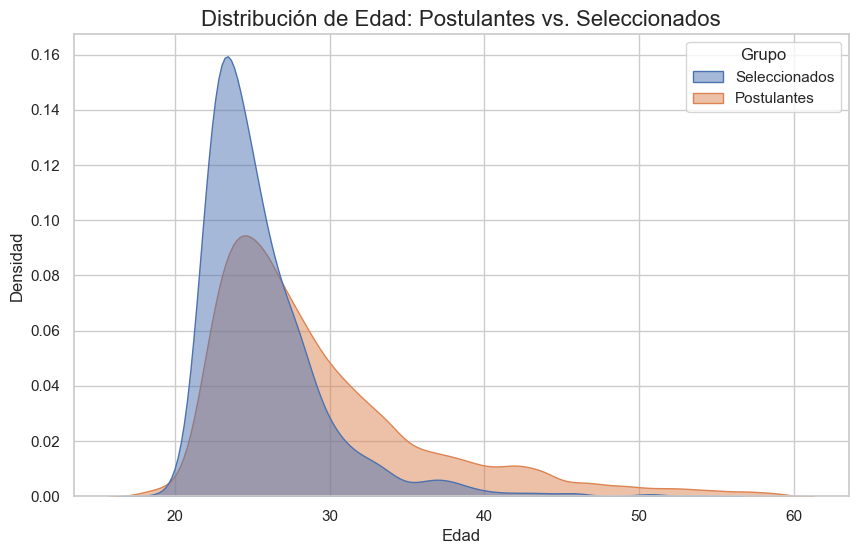

In [222]:
df_sel_comp = df_eda_seleccionados[['Edad']].copy()
df_sel_comp['Grupo'] = 'Seleccionados'


df_gen_comp = df_eda_general[['Edad']].copy()
df_gen_comp['Grupo'] = 'Postulantes'


df_comparativo_edad = pd.concat([df_sel_comp, df_gen_comp])

df_comparativo_edad = df_comparativo_edad.dropna(subset=['Edad'])
df_comparativo_edad = df_comparativo_edad[
    (df_comparativo_edad['Edad'] >= 18) & (df_comparativo_edad['Edad'] < 60)
]

plt.figure(figsize=(10, 6))
ax = sns.kdeplot(
    data=df_comparativo_edad,
    x='Edad',
    hue='Grupo',
    fill=True,
    alpha=0.5,
    common_norm=False
)

ax.set_title('Distribución de Edad: Postulantes vs. Seleccionados', fontsize=16)
ax.set_xlabel('Edad')
ax.set_ylabel('Densidad')
plt.show();

C:\Users\crist\AppData\Local\Temp\ipykernel_41836\3149413856.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


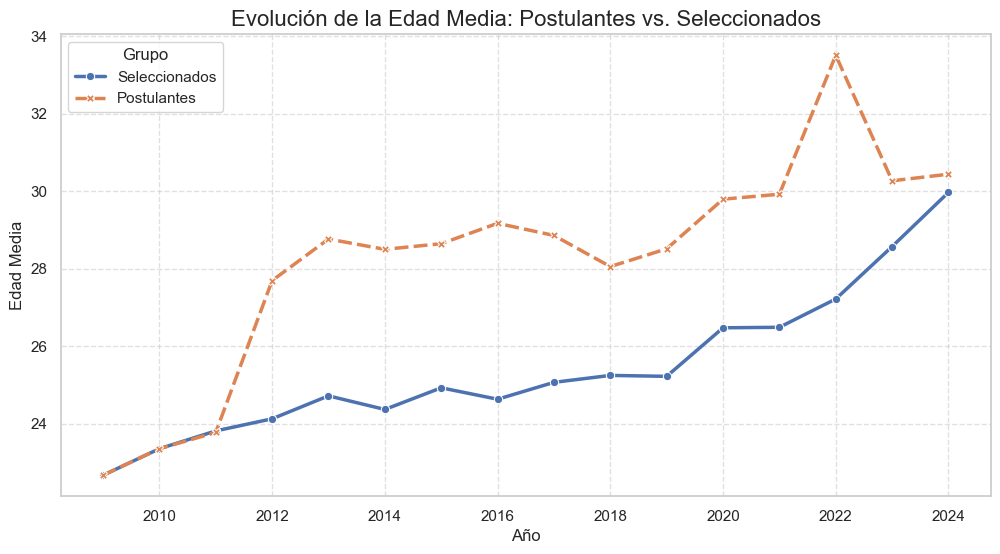

In [223]:
df_gen_temp = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_gen_temp = df_gen_temp.dropna(subset=['Año', 'Edad'])
df_gen_temp['Año'] = df_gen_temp['Año'].astype(int)


df_sel_temp = df_eda_seleccionados.dropna(subset=['Año', 'Edad'])
df_sel_temp['Año'] = df_sel_temp['Año'].astype(int)


avg_age_sel = df_sel_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_sel['Grupo'] = 'Seleccionados'

avg_age_gen = df_gen_temp.groupby('Año')['Edad'].mean().reset_index(name='Edad Media')
avg_age_gen['Grupo'] = 'Postulantes'

df_comparativo_temporal = pd.concat([avg_age_sel, avg_age_gen])


plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    data=df_comparativo_temporal,
    x='Año',
    y='Edad Media',
    hue='Grupo',
    style='Grupo',
    markers=True,
    linewidth=2.5
)

ax.set_title('Evolución de la Edad Media: Postulantes vs. Seleccionados', fontsize=16)
ax.set_xlabel('Año')
ax.set_ylabel('Edad Media')
#ax.set(xlim=(2010, 2025))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Grupo')
plt.show();

Al observar ambos gráficos, se aprecia una clara tendencia al rejuvenecimiento en las edades tanto de los postulantes como de los seleccionados a lo largo de los años. En los últimos periodos, la edad media de los seleccionados se ha mantenido alrededor de cuatro años por debajo de la de los postulantes, lo que sugiere que los candidatos más jóvenes tienden a tener mayores probabilidades de ser seleccionados.

Esta diferencia constante plantea una interrogante relevante: ¿la edad actúa realmente como un factor determinante en el proceso de selección, o más bien el enfoque institucional hacia postulantes más jóvenes ha provocado una disminución en la participación de personas mayores?

### 5.1.2 Analisis de tendencias etarias en los procesos de seleccion

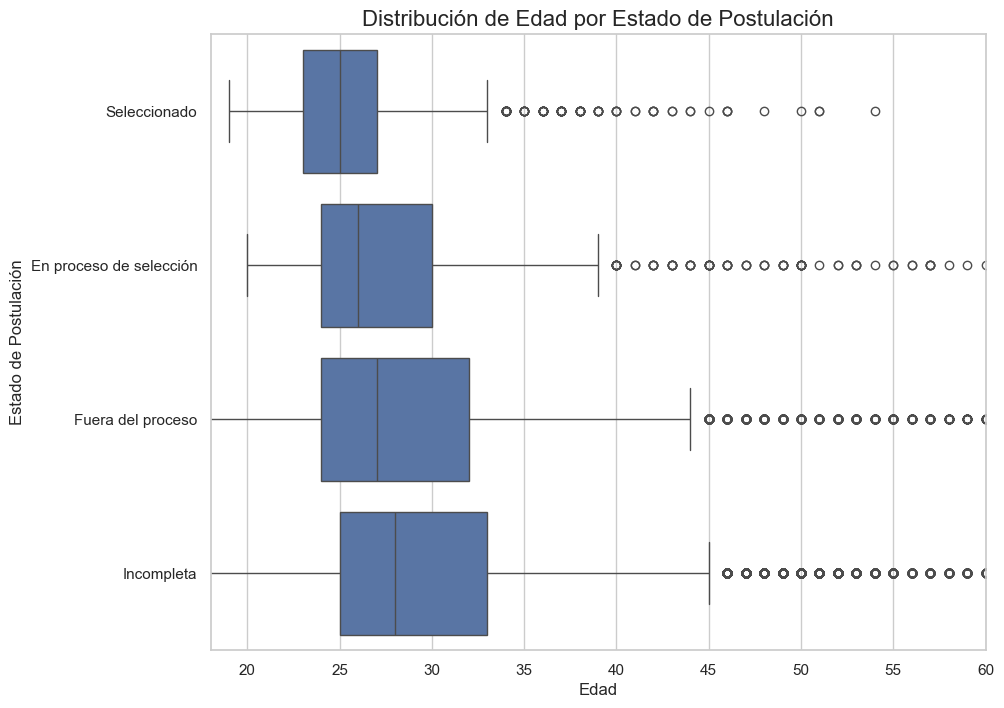

In [224]:
plt.figure(figsize=(10, 8))

ax = sns.boxplot(data=df_eda_general,
            x='Edad',
            y='Resumen Estado Postulación')

plt.title('Distribución de Edad por Estado de Postulación', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Estado de Postulación', fontsize=12)
ax.set_xlim(18, 60)

plt.show()

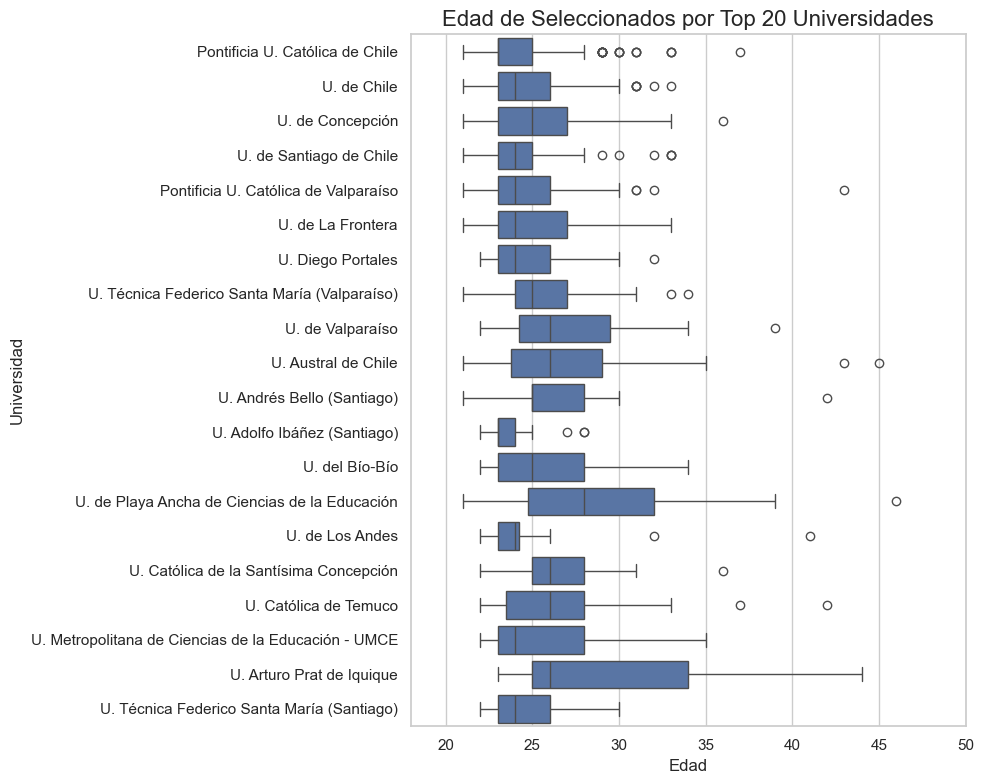

In [225]:
conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()

N = 20
universidades_top_N = conteo_universidades.head(N).index

df_top_N = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(universidades_top_N)
]


plt.figure(figsize=(10, 8))


ax = sns.boxplot(data=df_top_N,
            x='Edad',
            y='Universidad',
            order=universidades_top_N)

plt.title(f'Edad de Seleccionados por Top {N} Universidades', fontsize=16)
plt.xlabel('Edad', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
ax.set_xlim(18, 50)
plt.tight_layout()
plt.show()
plt.show()

Se puede observar de los gráficos que la mayoría de los postulantes se concentran entre los 30 y 40 años, este rango etario también predomina entre los seleccionados, lo que sugiere que se favorece a perfiles con cierta experiencia profesional.
Los postulantes mas jóvenes tienden ser quienes no completan su postulación o quedan fuera del proceso, mientras que el rango etario de mayores de 50 años participan en menor medida.
En cuanto a las universidades, se puede observar que los seleccionados de universidades privadas de la región metropolitana presentan edades mas bajas, mientras que los provenientes de universidades regionales o tradicionales presentan edades mayores, esto refleja diversidad etaria del grupo seleccionado.

### 5.1.3 Analisis de distribucion entre universidades, carrera y edad

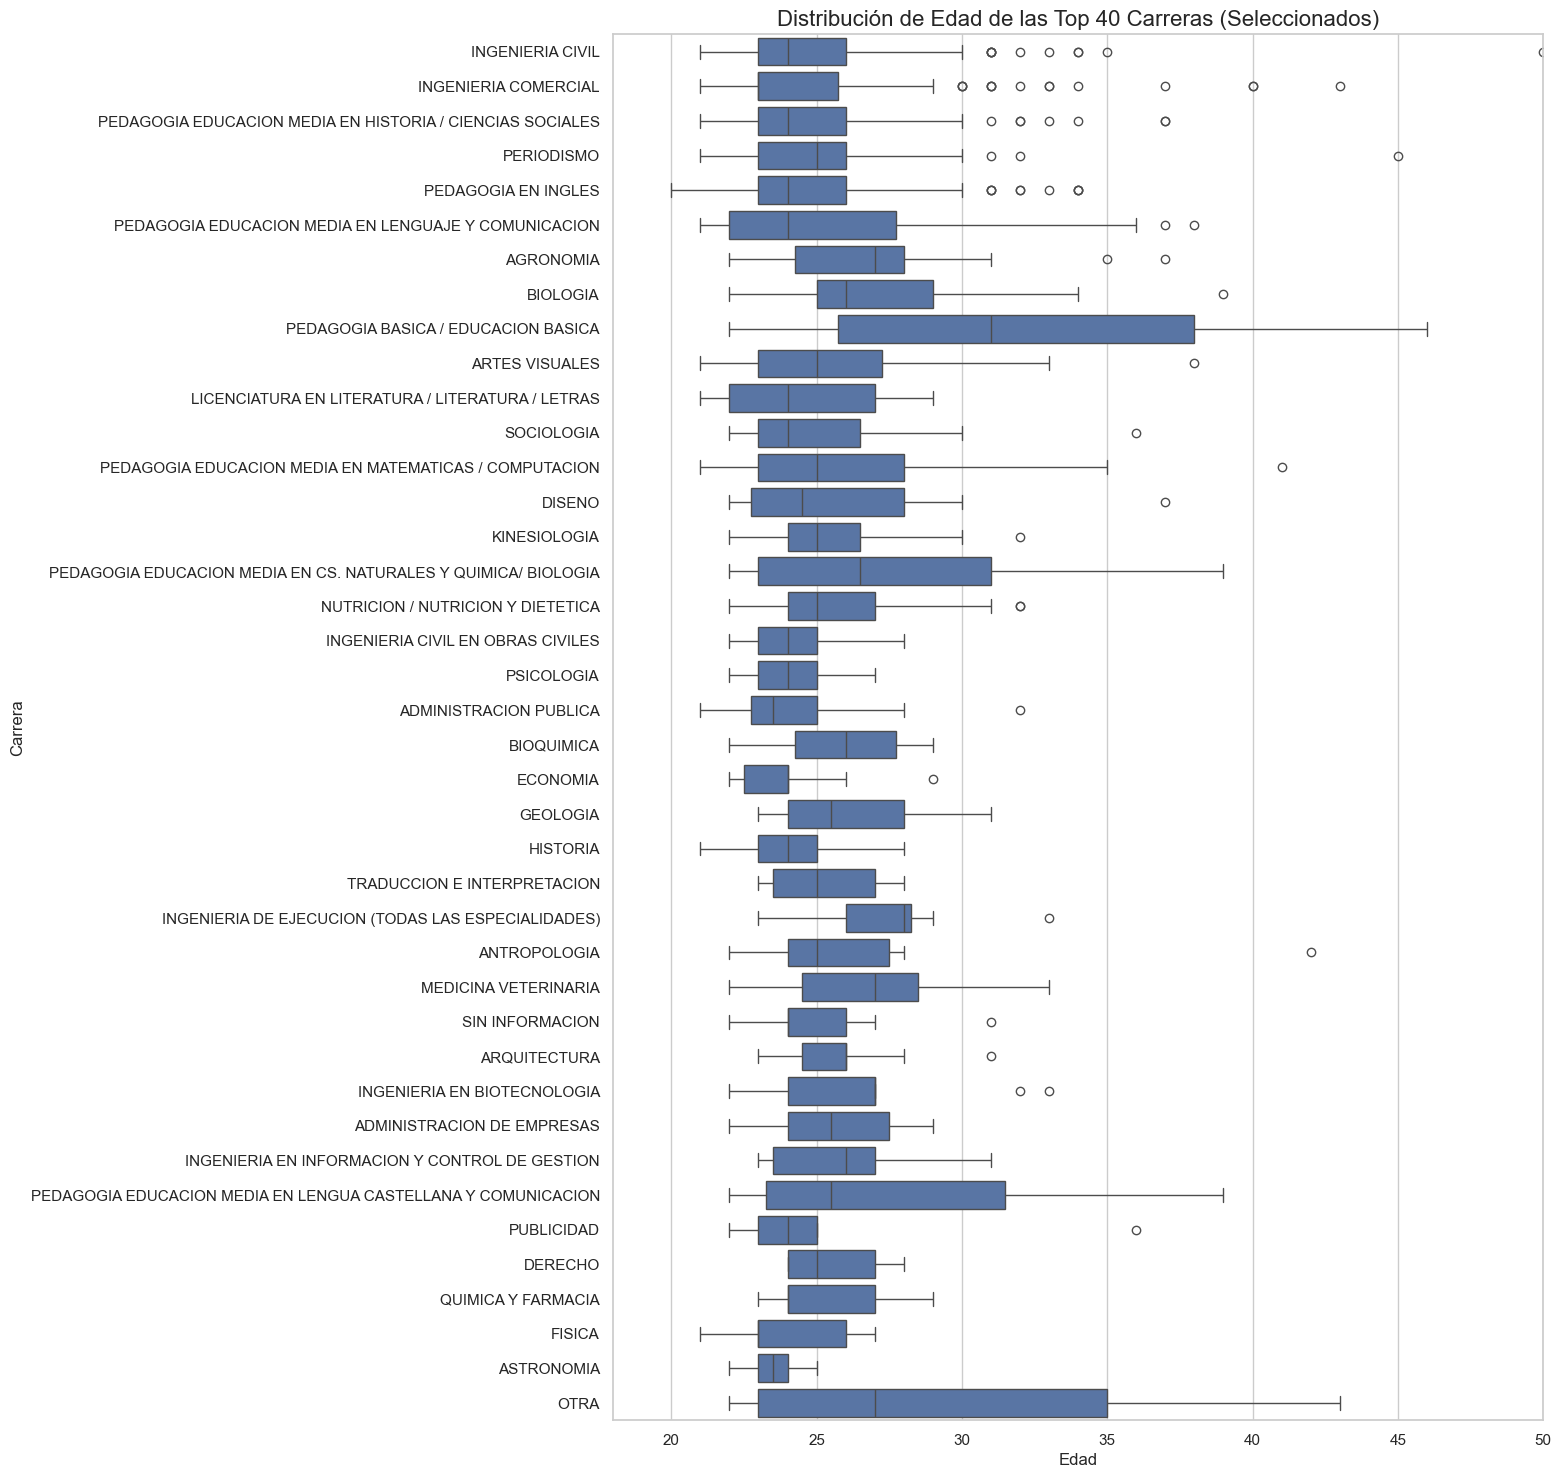

In [226]:
N = 40

# Contamos cuántos seleccionados hay por carrera
conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()

# Obtenemos la lista de las Top N carreras (sus nombres)
carreras_top_N = conteo_carreras.head(N).index

# Filtramos el DataFrame para quedarnos solo con las filas de esas Top N carreras
df_filtrado_topN = df_eda_seleccionados[
    df_eda_seleccionados['Carrera'].isin(carreras_top_N)
]
altura_figura = max(15, N * 0.45)

fig, ax = plt.subplots(1, 1, figsize=(12, altura_figura))

sns.boxplot(
    data=df_filtrado_topN,
    x='Edad',
    y='Carrera',
    order=carreras_top_N,
    ax=ax
)

ax.set_title(f'Distribución de Edad de las Top {N} Carreras (Seleccionados)', fontsize=16)
ax.set_xlabel('Edad', fontsize=12)
ax.set_ylabel('Carrera', fontsize=12)
ax.set_xlim(18, 50)

plt.show()

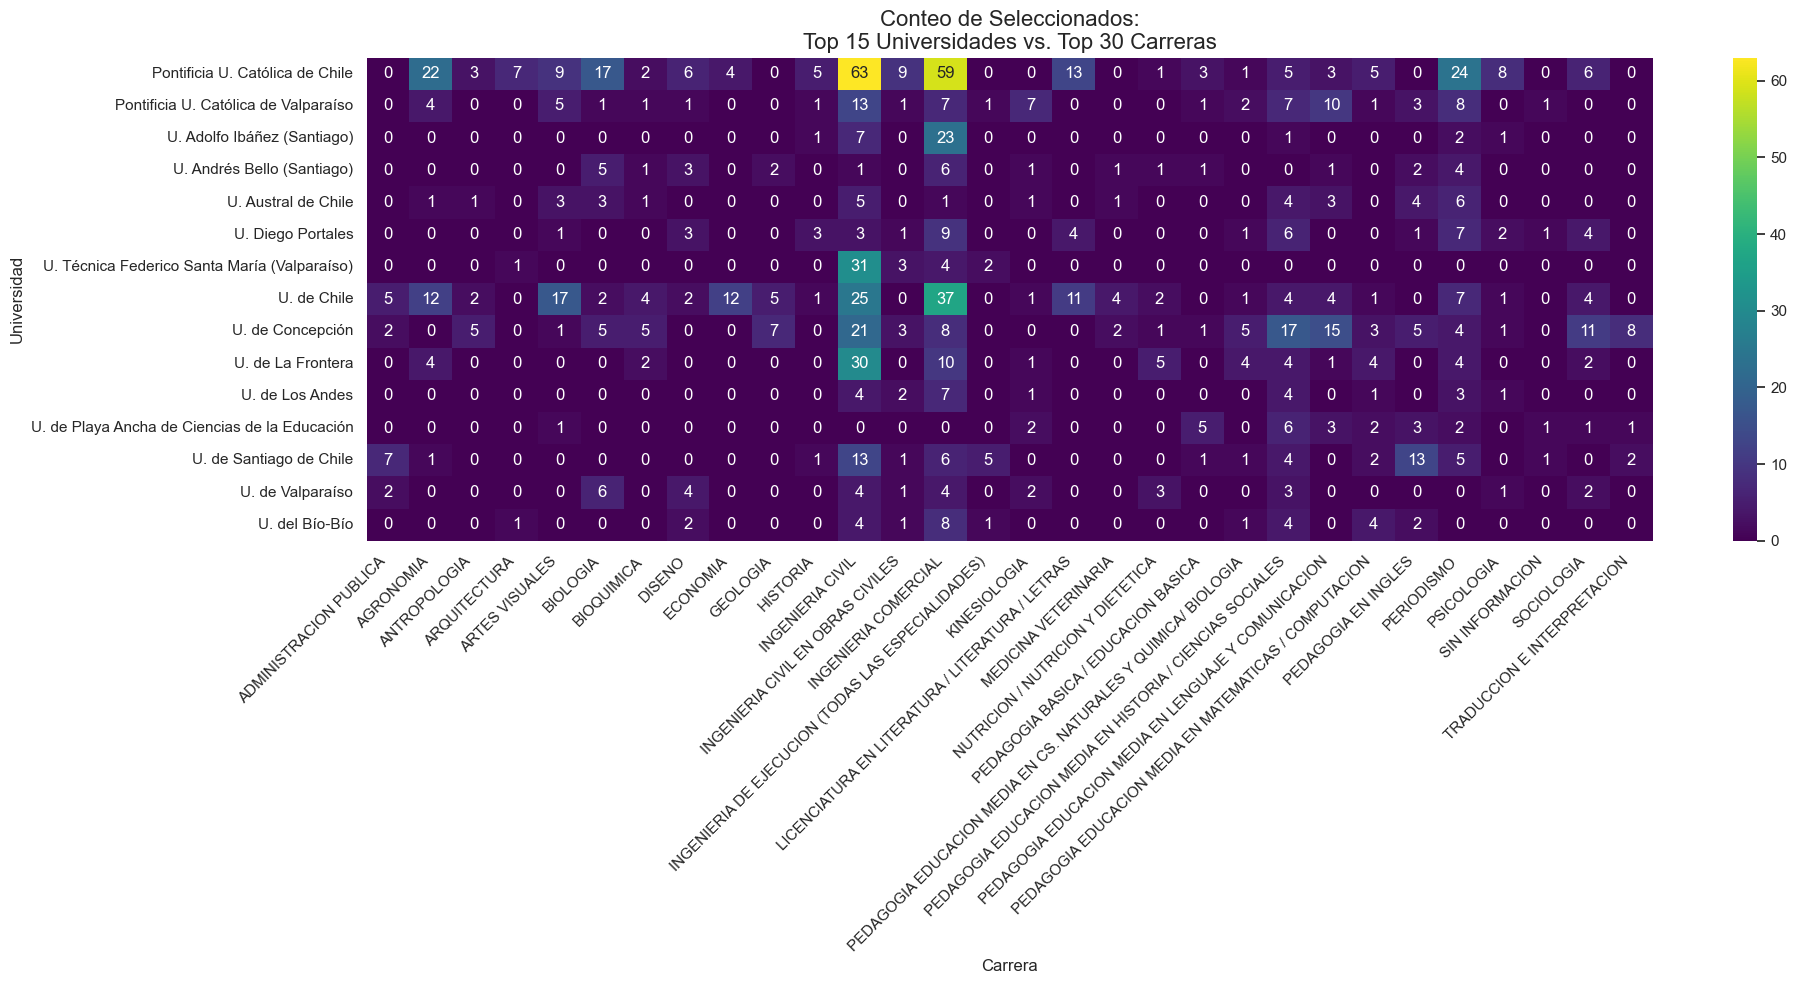

In [227]:
N_universidades = 15
N_carreras = 30

conteo_universidades = df_eda_seleccionados['Universidad'].value_counts()
top_universidades = conteo_universidades.head(N_universidades).index


conteo_carreras = df_eda_seleccionados['Carrera'].value_counts()
top_carreras = conteo_carreras.head(N_carreras).index


df_filtrado_heatmap = df_eda_seleccionados[
    df_eda_seleccionados['Universidad'].isin(top_universidades) &
    df_eda_seleccionados['Carrera'].isin(top_carreras)
]

tabla_contingencia = pd.crosstab(
    df_filtrado_heatmap['Universidad'],
    df_filtrado_heatmap['Carrera']
)


fig, ax = plt.subplots(1, 1, figsize=(20, 10))

sns.heatmap(
    tabla_contingencia,
    annot=True,
    fmt='d',
    cmap='viridis',
    ax=ax
)


ax.set_title(f'Conteo de Seleccionados:\nTop {N_universidades} Universidades vs. Top {N_carreras} Carreras', fontsize=16)
ax.set_xlabel('Carrera', fontsize=12)
ax.set_ylabel('Universidad', fontsize=12)


plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)

fig.tight_layout()
plt.show()

## 5.2 Tendencias en el tiempo (por universidad/carrera)
Para cumplir con los objetivos del proyecto, no basta con saber qué universidades o carreras tienen más seleccionados en total. Necesitamos entender la evolución y la consistencia de estas cifras (Objetivos 1 y 2). El reclutamiento es un proceso dinámico; las universidades que eran prioritarias hace una década podrían no serlo hoy.

Para analizar las tendencias, se generaron tres visualizaciones clave, cada una con un propósito específico. En todas ellas, se decidió filtrar por el "Top 10" (de universidades o carreras) como un equilibrio y para mayor legibilidad, dado que mostrar todas las categorías resultaría en un gráfico de indescifrable.

In [228]:
# @title
df_general_temporal = df_eda_general.rename(columns={'Año Pech': 'Año'})
df_general_temporal = df_general_temporal.dropna(subset=['Año'])
df_general_temporal['Año'] = df_general_temporal['Año'].astype(int)

df_seleccionados_temporal = df_eda_seleccionados.dropna(subset=['Año'])
df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)

C:\Users\crist\AppData\Local\Temp\ipykernel_41836\1586719865.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_seleccionados_temporal['Año'] = df_seleccionados_temporal['Año'].astype(int)


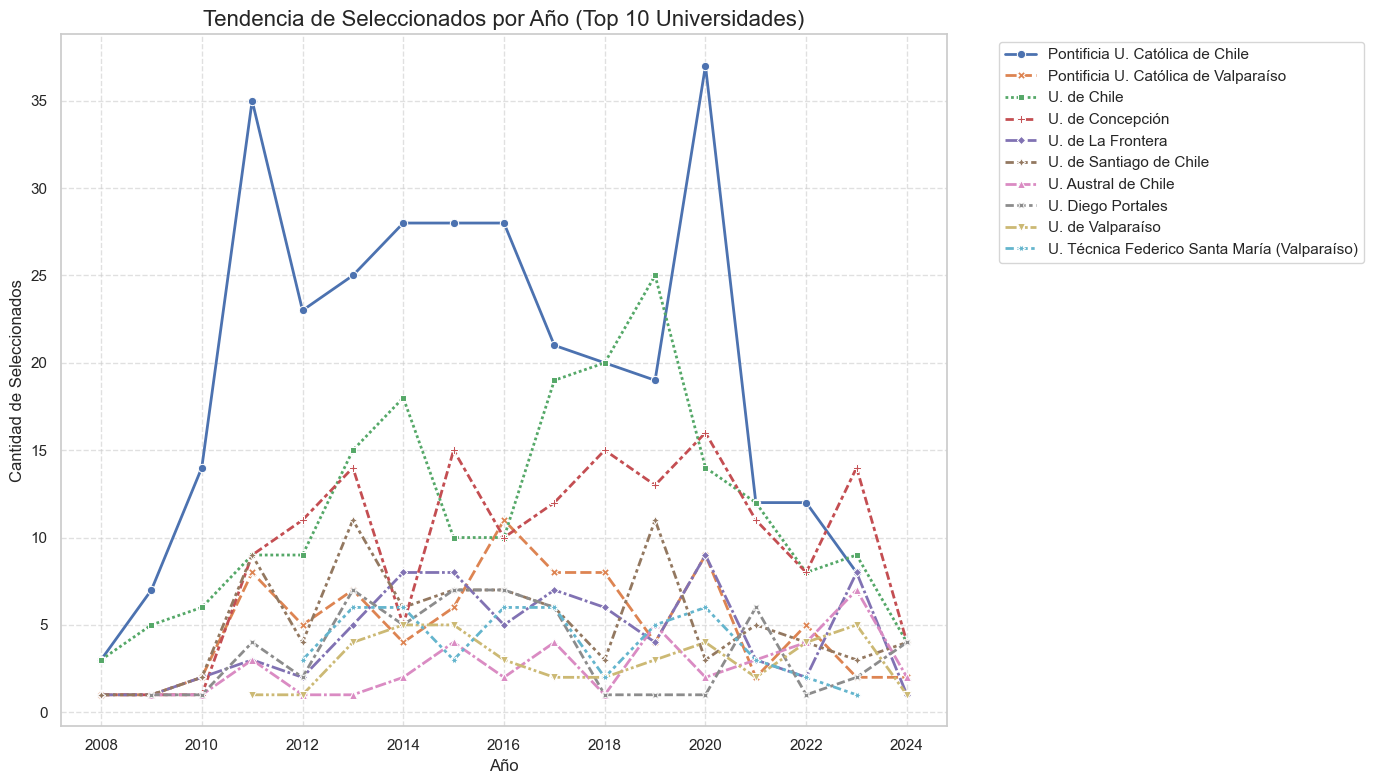

In [229]:
# @title


N_Ues = 10
top_universidades = df_seleccionados_temporal['Universidad'].value_counts().head(N_Ues).index


df_seleccionados_top_u = df_seleccionados_temporal[
    df_seleccionados_temporal['Universidad'].isin(top_universidades)
]


tendencia_por_universidad = df_seleccionados_top_u.groupby(
    ['Año', 'Universidad']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_universidad,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Universidad',
             style='Universidad',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Ues} Universidades)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

Este gráfico muestra el conteo absoluto de seleccionados provenientes de las 10 universidades con más seleccionados históricos.

Resultados y Conclusiones Preliminares:

- Es evidente que la Pontificia U. Católica de Chile (línea azul sólida) y la U. de Chile (línea verde punteada) dominan en términos de volumen de seleccionados, superandoa las demás.

- Las cifras no son estables. Se observa un peak extremo para la PUC alrededor de 2021. Esto genera la pregunta:
  1. ¿Qué ocurrió ese año?
  2. ¿Se llevo a cabo una campaña de  reclutamiento diferente?
  3. ¿Fue un efecto de la pandemia?

- Casi todas las universidades muestran una fuerte caída en el número de seleccionados después de 2021-2022. Esto debe investigarse.
  1. ¿Es un reflejo de datos incompletos?
  2. ¿Es una señal de una crisis en el reclutamiento de Enseña Chile?

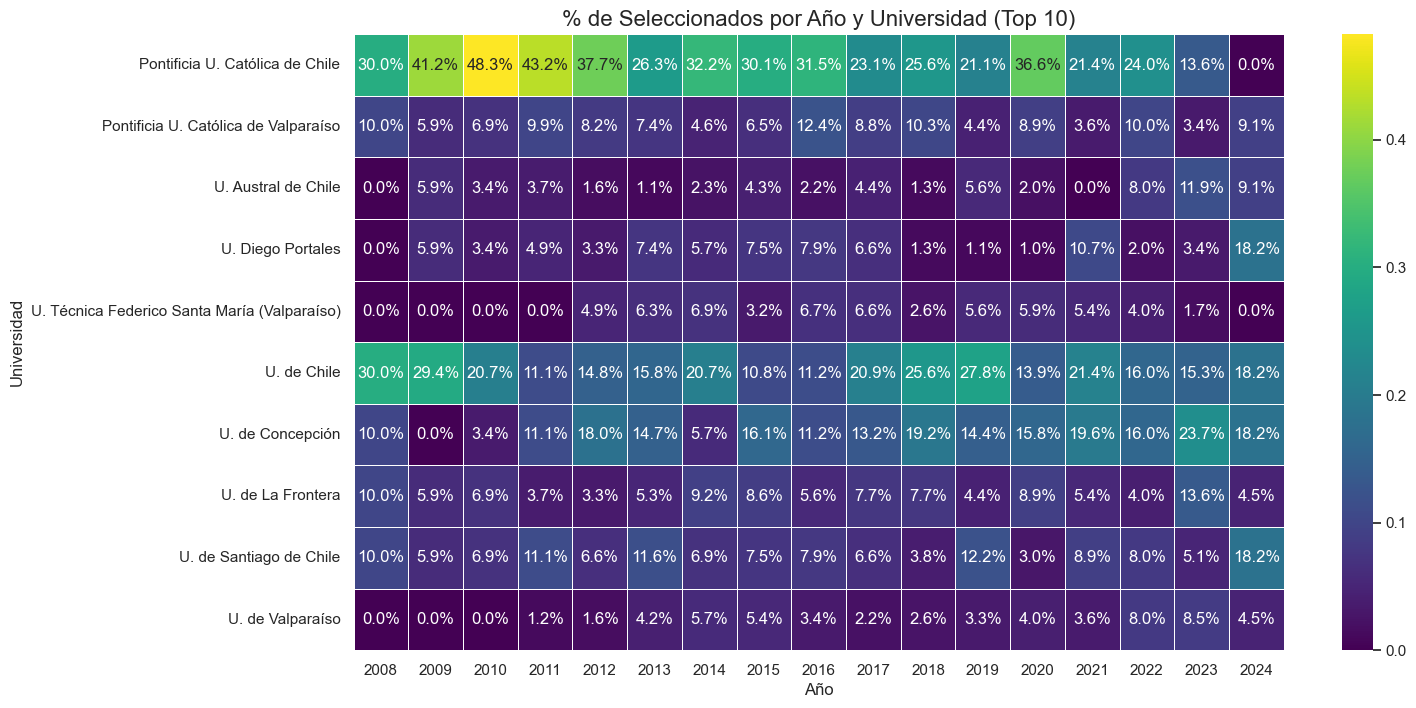

In [230]:
# @title
df_pivot_u = tendencia_por_universidad.pivot_table(
    index='Universidad',
    columns='Año',
    values='Cantidad Seleccionados'
).fillna(0)

df_pivot_u_norm = df_pivot_u.apply(lambda x: x / x.sum(), axis=0)


plt.figure(figsize=(15, 8))
sns.heatmap(df_pivot_u_norm,
            annot=True,
            fmt='.1%',
            cmap='viridis',
            linewidths=.5)

plt.title(f'% de Seleccionados por Año y Universidad (Top {N_Ues})', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Universidad', fontsize=12)
plt.show();

Este grafico muestra qué porcentaje del total de seleccionados de un año específico aportó cada una de las Top 10 universidades.

Resultados y Conclusiones Preliminares:

Este gráfico responde directamente a la Pregunta 5. Confirma que la concentración en la PUC y U. de Chile es real. En la mayoría de los años, estas dos instituciones suman entre el 40% y el 60% de todos los seleccionados  Esto sugiere un fuerte sesgo histórico hacia estas instituciones.

La U. de Concepción y PUCV muestran una participación proporcional consistente (8%-15%) del total anual. Esto las posiciona como objetivos de reclutamiento fiables.

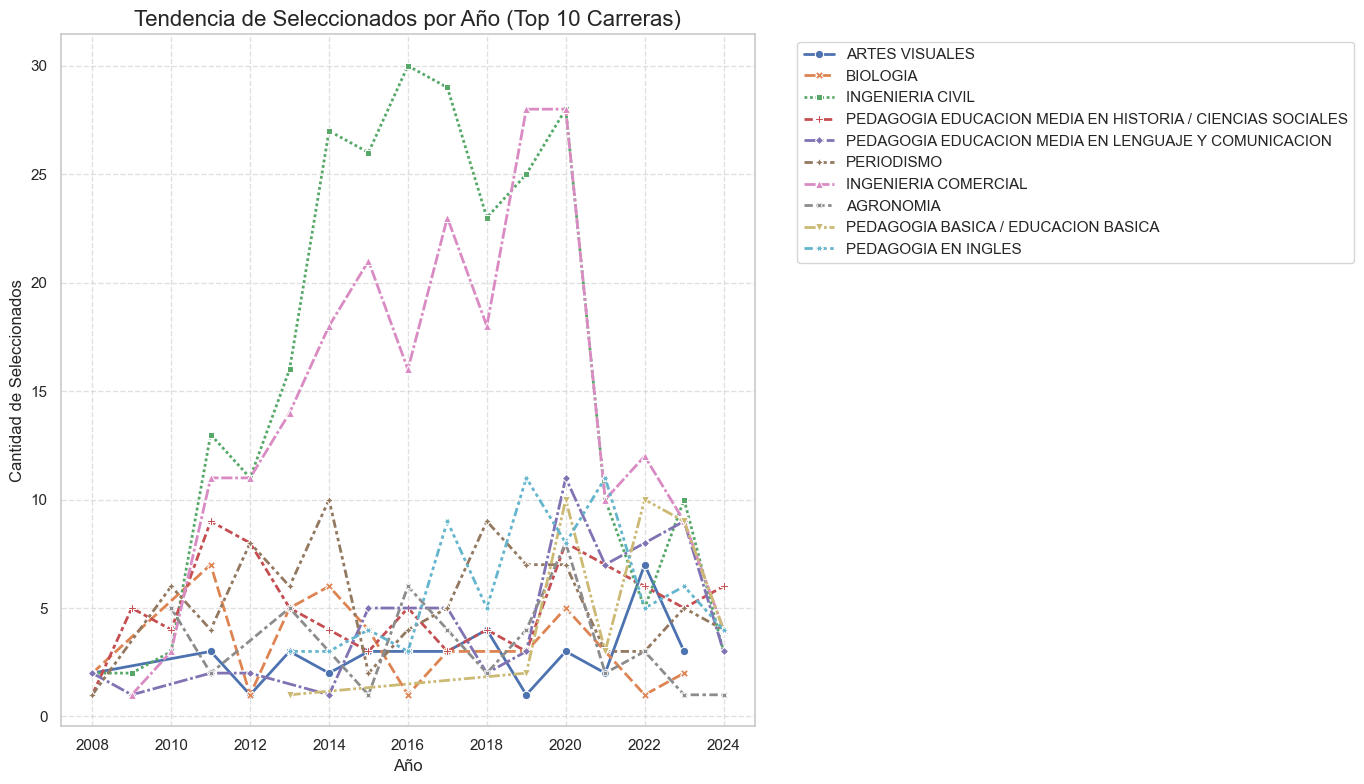

In [231]:
# @title
N_Carreras = 10
top_carreras = df_seleccionados_temporal['Carrera'].value_counts().head(N_Carreras).index

df_seleccionados_top_c = df_seleccionados_temporal[
    df_seleccionados_temporal['Carrera'].isin(top_carreras)
]

tendencia_por_carrera = df_seleccionados_top_c.groupby(
    ['Año', 'Carrera']
).size().reset_index(name='Cantidad Seleccionados')

plt.figure(figsize=(14, 8))
sns.lineplot(data=tendencia_por_carrera,
             x='Año',
             y='Cantidad Seleccionados',
             hue='Carrera',
             style='Carrera',
             markers=True,
             linewidth=2)

plt.title(f'Tendencia de Seleccionados por Año (Top {N_Carreras} Carreras)', fontsize=16)
plt.xlabel('Año', fontsize=12)
plt.ylabel('Cantidad de Seleccionados', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show();

El grafico muestra el número de seleccionados provenientes de las 10 carreras más frecuentes en la historia del programa.

Resultados y Conclusiones Preliminares:

- El hallazgo más importante es la dominancia de dos carreras: Ingenieria Civil (línea roja punteada) e Ingeniería Comercial (línea azul). Históricamente, estas dos carreras son las que mas aportan a los seleccionados.

- Esto impacta directamente el Objetivo 3 (identificar carreras prioritarias). Estas dos son, por volumen, las más importantes.

- Este gráfico genera preguntas interesantes para Enseña Chile:

  1. ¿Por qué estas dos carreras? ¿Son el foco principal de las campañas de reclutamiento? ¿O son las que calzan con el perfil de reclutamiento?

  2. ¿Por qué carreras aparentemente más alineadas con la misión como las Pedagogías tienen números tan bajos?

  3. ¿Desea la fundación diversificar este perfil?

5.4 Exploracion mineduc

In [232]:
df_titulados_completo.head()

,cat_periodo,nomb_carrera,nivel_carrera_1,nombre_titulo_obtenido,nomb_inst,region_sede,area_conocimiento,carrera_agrupada
0,2024,CONTADOR AUDITOR,Profesional Con Licenciatura,CONTADOR AUDITOR,UNIVERSIDAD SAN SEBASTIAN,Metropolitana,Administración y Comercio,AUDITOR
1,2024,INGENIERIA CIVIL MATEMATICA,Profesional Con Licenciatura,INGENIERO CIVIL MATEMATICO,UNIVERSIDAD DE CONCEPCION,Biobío,Ciencias Básicas,INGENIERIA
2,2024,INGENIERIA DE EJECUCION EN PREVENCION DE RIESGOS,Profesional Sin Licenciatura,INGENIERO DE EJECUCION EN PREVENCION DE RIESGOS,UNIVERSIDAD ARTURO PRAT,La Araucanía,Tecnología,INGENIERIA
3,2024,INGENIERIA COMERCIAL,Profesional Con Licenciatura,INGENIERO COMERCIAL CON MENCION EN ADMINISTRACION,UNIVERSIDAD DE LAS AMERICAS,Biobío,Administración y Comercio,INGENIERIA
4,2024,INGENIERIA EN CONSTRUCCION MENCION GESTION DE ...,Profesional Con Licenciatura,INGENIERO EN CONSTRUCCION MENCION GESTION DE O...,UNIVERSIDAD DE ACONCAGUA,Metropolitana,Tecnología,INGENIERIA


In [233]:
conteo_agrupada = df_titulados_completo['carrera_agrupada'].value_counts()

<Figure size 1200x600 with 0 Axes>

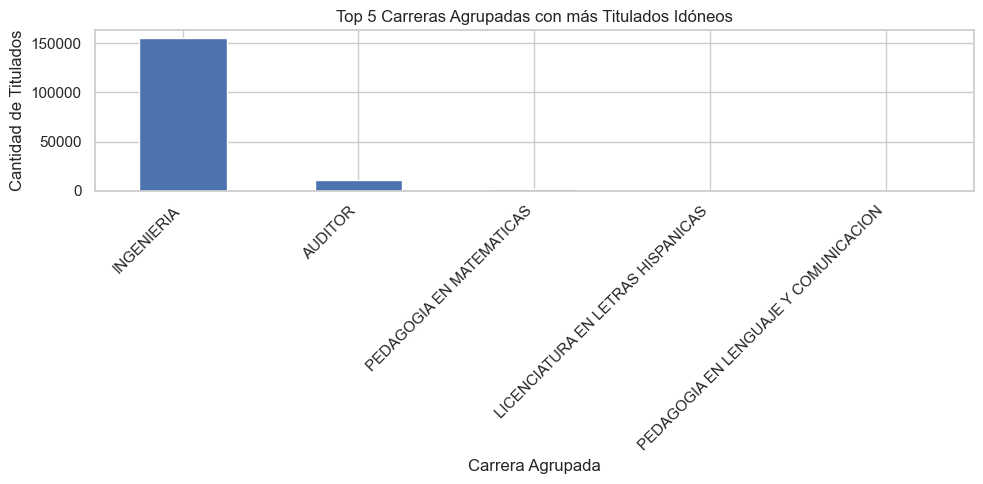

In [234]:
plt.figure(figsize=(12, 6))
plt.figure(figsize=(10, 5))
conteo_agrupada.head(5).plot(kind='bar')
plt.title('Top 5 Carreras Agrupadas con más Titulados Idóneos')
plt.xlabel('Carrera Agrupada')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


### Conteo de Titulados por Institución (Universidades con más Pool)
nomb_inst
UNIVERSIDAD TECNOLOGICA DE CHILE INACAP          21991
UNIVERSIDAD ANDRES BELLO                         16404
UNIVERSIDAD TECNICA FEDERICO SANTA MARIA          8782
UNIVERSIDAD DE SANTIAGO DE CHILE                  8118
UNIVERSIDAD DE CHILE                              7507
UNIVERSIDAD ADOLFO IBAÑEZ                         6604
UNIVERSIDAD ARTURO PRAT                           6021
PONTIFICIA UNIVERSIDAD CATOLICA DE CHILE          5642
UNIVERSIDAD SAN SEBASTIAN                         5332
PONTIFICIA UNIVERSIDAD CATOLICA DE VALPARAISO     5276
Name: count, dtype: int64


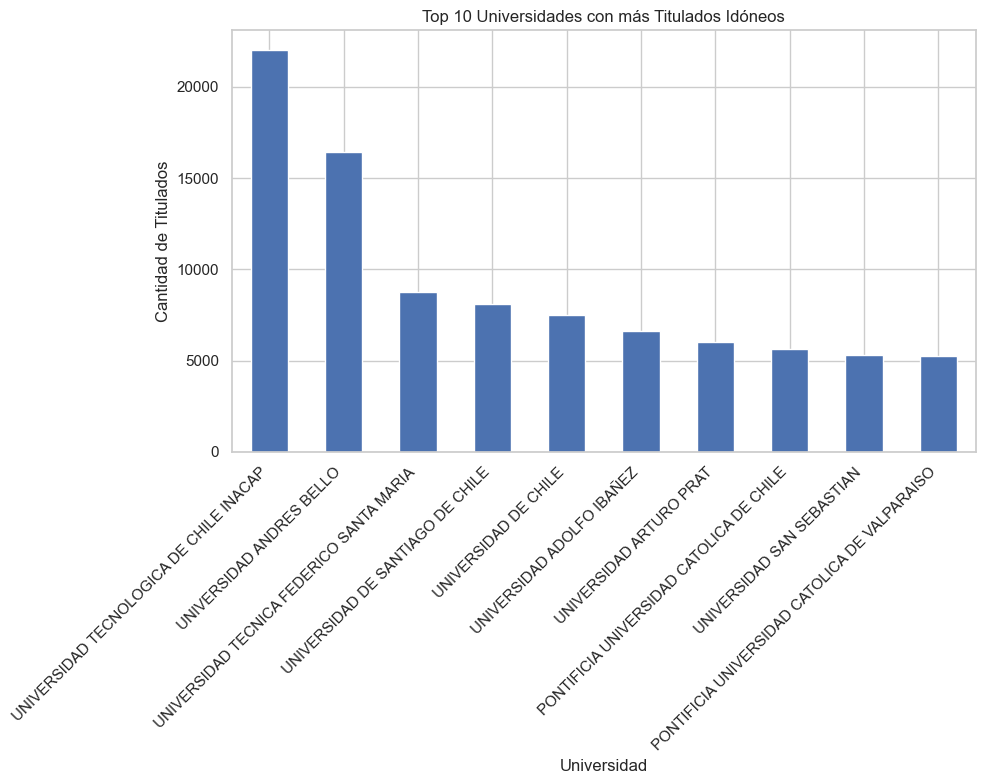

In [235]:
print("\n### Conteo de Titulados por Institución (Universidades con más Pool)")
conteo_inst = df_titulados_completo['nomb_inst'].value_counts()
print(conteo_inst.head(10))

plt.figure(figsize=(10, 8))
conteo_inst.head(10).plot(kind='bar')
plt.title('Top 10 Universidades con más Titulados Idóneos')
plt.xlabel('Universidad')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

C:\Users\crist\AppData\Local\Temp\ipykernel_41836\1349814255.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_titulados_completo.groupby('region_sede').size().sort_values(ascending=False).plot(kind='bar')


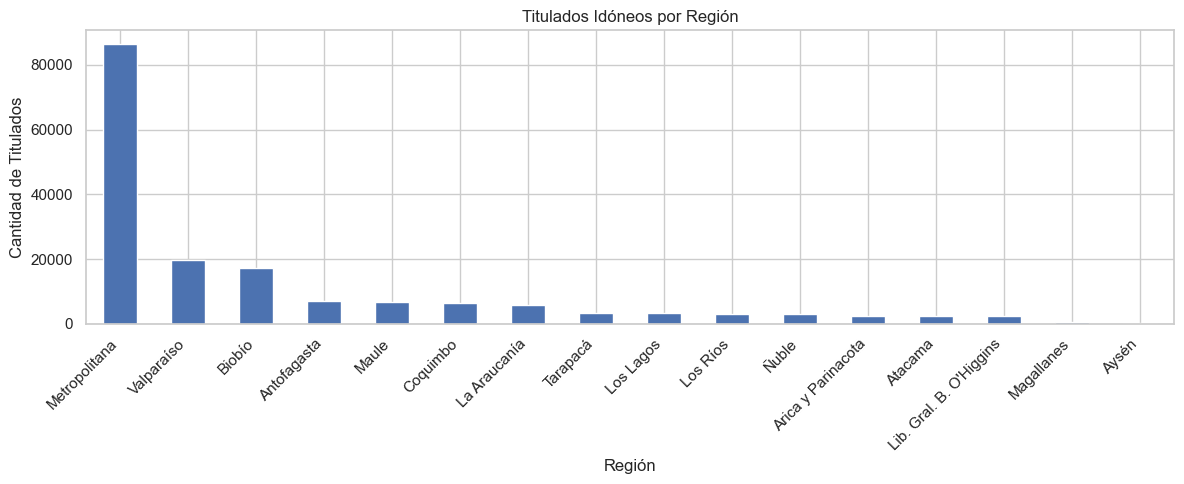

In [236]:
plt.figure(figsize=(12, 5))
df_titulados_completo.groupby('region_sede').size().sort_values(ascending=False).plot(kind='bar')
plt.title('Titulados Idóneos por Región')
plt.xlabel('Región')
plt.ylabel('Cantidad de Titulados')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [237]:
# Estadísticas descriptivas del puntaje de corte PAES
#print("\n### Estadísticas Descriptivas del Puntaje de Corte PAES (General)")
#print(df_titulados_completo['puntaje_corte_paes'].describe())

In [238]:
# plt.figure(figsize=(12, 6))
# sns.boxplot(x='carrera_agrupada', y='puntaje_corte_paes',
            # data=df_titulados_completo[df_titulados_completo['carrera_agrupada'].isin(conteo_agrupada.head(5).index)])
# plt.title('Distribución del Puntaje de Corte PAES por Top 5 Carreras Agrupadas')
# plt.xlabel('Carrera Agrupada')
# plt.ylabel('Puntaje de Corte PAES')
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

2.3 Puntajes ponderados de matriculados educación superior 2020-2024

In [239]:
BASE_PATH = Path("datasets/puntajes/")

def cambiar_formato_puntajes(series: pd.Series) -> pd.Series:
    s = series.astype(str).str.replace(",", ".", regex=False).str.strip()
    return pd.to_numeric(s, errors="coerce")

def crear_dfs(year: int, base_path: Path) -> pd.DataFrame:
    csv_path = base_path / f"ArchivoMatr_Adm{year}.csv"
    df = pd.read_csv(csv_path, sep=";")
    return df

df_2020 = crear_dfs(2020, BASE_PATH)
df_2021 = crear_dfs(2021, BASE_PATH)
df_2022 = crear_dfs(2022, BASE_PATH)
df_2023 = crear_dfs(2023, BASE_PATH)
df_2024 = crear_dfs(2024, BASE_PATH)

print("Puntajes 2020")
display(df_2020)
df_2020.info()
print("\n")
print("Puntajes 2021")
display(df_2021)
df_2021.info()
print("\n")
print("Puntajes 2022")
display(df_2022)
df_2022.info()
print("\n")
print("Puntajes 2023")
display(df_2023)
df_2023.info()
print("\n")
print("Puntajes 2024")
display(df_2024)
df_2024.info()


Puntajes 2020


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_797737971778,49,49005,1,3,529,2,1
1,id_056530575654,27,27023,1,1,534,1,1
2,id_666606670669,41,41068,1,1,"531,7",1,1
3,id_902969073298,16,16060,1,1,"692,05",1,1
4,id_570065773007,41,41194,1,1,"517,6",1,1
...,...,...,...,...,...,...,...,...
97987,id_5093580849461,50,50528,1,7,"477,67",1,1
97988,id_5593595644442,14,14072,1,1,"624,1",1,1
97989,id_9866988748576,15,15170,1,1,"722,3",1,1
97990,id_9866988341176,44,44001,1,1,"573,5",1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97992 entries, 0 to 97991
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          97992 non-null  object
 1   CODIGO_UNIV     97992 non-null  int64 
 2   CODIGO          97992 non-null  int64 
 3   VIA             97992 non-null  int64 
 4   PREFERENCIA     97992 non-null  int64 
 5   PTJE_POND       97992 non-null  object
 6   POND_ANYO_ACAD  97992 non-null  int64 
 7   TIPO_MATRICULA  97992 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 6.0+ MB


Puntajes 2021


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_896138975615,11,11021,1,2,"608,8",1,1
1,id_996709977679,20,20098,1,10,"588,25",1,2
2,id_996609977662,11,11087,1,2,"639,4",1,1
3,id_719207177929,52,52497,1,1,575,1,1
4,id_250302574037,53,53309,1,5,"579,45",1,1
...,...,...,...,...,...,...,...,...
92282,id_129414246719,26,26301,1,1,"610,9",1,1
92283,id_466541647727,40,40021,1,1,"563,91",1,1
92284,id_056408548155,49,49016,1,1,"638,44",1,1
92285,id_166615640372,46,46401,1,10,542,1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92287 entries, 0 to 92286
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          92287 non-null  object
 1   CODIGO_UNIV     92287 non-null  int64 
 2   CODIGO          92287 non-null  int64 
 3   VIA             92287 non-null  int64 
 4   PREFERENCIA     92287 non-null  int64 
 5   PTJE_POND       92287 non-null  object
 6   POND_ANYO_ACAD  92287 non-null  int64 
 7   TIPO_MATRICULA  92287 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 5.6+ MB


Puntajes 2022


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
0,id_712837177285,34,34057,1,1,"548,6",2,1
1,id_962409670243,24,24017,1,2,"465,3",1,1
2,id_781807879181,41,41034,1,1,"501,2",1,1
3,id_155001578503,16,16100,1,1,"668,1",1,1
4,id_170201772022,11,11072,1,1,"608,2",1,1
...,...,...,...,...,...,...,...,...
95933,id_7666786448959,16,16004,1,2,"704,7",1,3
95934,id_7666786449275,45,45005,1,1,"615,3",1,1
95935,id_7666786443922,20,20098,3,2,"830,706",1,1
95936,id_7666786249480,12,12038,1,2,"652,2",1,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95938 entries, 0 to 95937
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID_aux          95938 non-null  object
 1   CODIGO_UNIV     95938 non-null  int64 
 2   CODIGO          95938 non-null  int64 
 3   VIA             95938 non-null  int64 
 4   PREFERENCIA     95938 non-null  int64 
 5   PTJE_POND       95938 non-null  object
 6   POND_ANYO_ACAD  95938 non-null  int64 
 7   TIPO_MATRICULA  95938 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 5.9+ MB


Puntajes 2023


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
0,id_267832678788,30,30055,1,1,513.60,1
1,id_016130170616,45,45021,1,1,565.85,1
2,id_514305173430,56,56524,1,3,724.70,1
3,id_042500470254,47,47303,1,1,697.60,1
4,id_699806974987,45,45009,1,2,722.00,1
...,...,...,...,...,...,...,...
111292,id_8198841548154,32,32012,1,1,591.45,1
111293,id_7666786944704,50,50201,1,1,580.50,1
111294,id_7666786243268,32,32055,1,1,733.50,3
111295,id_7666786649432,51,51185,1,9,593.40,1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 111297 entries, 0 to 111296
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   ID_aux          111297 non-null  object 
 1   CODIGO_UNIV     111297 non-null  int64  
 2   CODIGO          111297 non-null  int64  
 3   VIA             111297 non-null  int64  
 4   PREFERENCIA     111297 non-null  int64  
 5   PTJE_POND       111297 non-null  float64
 6   TIPO_MATRICULA  111297 non-null  int64  
dtypes: float64(1), int64(5), object(1)
memory usage: 5.9+ MB


Puntajes 2024


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
0,id_690126976014,51,51111,1,1,"709,9",1
1,id_831408370144,18,18075,1,1,"713,45",1
2,id_752607579265,44,44049,1,1,"876,1",1
3,id_772307770236,21,21043,1,1,"643,3",2
4,id_481904877199,41,41067,1,1,"638,7",1
...,...,...,...,...,...,...,...
118354,id_676664741483,30,30038,1,3,"795,2",1
118355,id_686660840696,19,19019,1,1,"617,75",1
118356,id_9866988747341,41,41060,1,2,"745,35",1
118357,id_7666786745599,47,47201,1,1,"681,5",1


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118359 entries, 0 to 118358
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ID_aux          118359 non-null  object
 1   CODIGO_UNIV     118359 non-null  int64 
 2   CODIGO          118359 non-null  int64 
 3   VIA             118359 non-null  int64 
 4   PREFERENCIA     118359 non-null  int64 
 5   PTJE_POND       118359 non-null  object
 6   TIPO_MATRICULA  118359 non-null  int64 
dtypes: int64(5), object(2)
memory usage: 6.3+ MB


In [240]:
# Aseguramos los datos de puntajes ponderados como numero
df_2020["PTJE_POND"] = cambiar_formato_puntajes(df_2020["PTJE_POND"])
df_2021["PTJE_POND"] = cambiar_formato_puntajes(df_2021["PTJE_POND"])
df_2022["PTJE_POND"] = cambiar_formato_puntajes(df_2022["PTJE_POND"])
df_2023["PTJE_POND"] = cambiar_formato_puntajes(df_2023["PTJE_POND"])
df_2024["PTJE_POND"] = cambiar_formato_puntajes(df_2024["PTJE_POND"])

In [241]:
# Inspeccion de nulos y duplicados
print(f"Cantidad de datos nulos por columna 2020")
print(df_2020.isnull().sum())
print(f"El df del año 2020 tiene {df_2020.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2021")
print(df_2021.isnull().sum())
print(f"El df del año 2021 tiene {df_2021.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2022")
print(df_2022.isnull().sum())
print(f"El df del año 2022 tiene {df_2022.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2023")
print(df_2023.isnull().sum())
print(f"El df del año 2023 tiene {df_2023.duplicated().sum()} filas con datos duplicados")
print("\n")

print(f"Cantidad de datos nulos por columna 2024")
print(df_2024.isnull().sum())
print(f"El df del año 2024 tiene {df_2024.duplicated().sum()} filas con datos duplicados")
print("\n")

Cantidad de datos nulos por columna 2020
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2020 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2021
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2021 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2022
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
POND_ANYO_ACAD    0
TIPO_MATRICULA    0
dtype: int64
El df del año 2022 tiene 0 filas con datos duplicados


Cantidad de datos nulos por columna 2023
ID_aux            0
CODIGO_UNIV       0
CODIGO            0
VIA               0
PREFERENCIA       0
PTJE_POND         0
TIPO_MATRICULA    0
dtype: in

In [242]:
display(df_2020.describe())
display(df_2021.describe())
display(df_2022.describe())
display(df_2023.describe())
display(df_2024.describe())

,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000,97992.000000
mean,29.974049,30079.499643,1.043197,1.771318,615.417596,1.125418,1.043789
std,13.816256,13850.435614,0.278055,1.597190,80.662268,0.331194,0.297642
min,11.000000,11001.000000,1.000000,1.000000,395.000000,1.000000,1.000000
25%,16.000000,16036.000000,1.000000,1.000000,554.150000,1.000000,1.000000
50%,30.000000,30085.000000,1.000000,1.000000,609.000000,1.000000,1.000000
75%,41.000000,41139.000000,1.000000,2.000000,668.400000,1.000000,1.000000
max,53.000000,53406.000000,3.000000,11.000000,970.952000,2.000000,4.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000,92287.000000
mean,30.706188,30814.127277,1.042509,1.876082,614.549159,1.100274,1.104153
std,14.418121,14455.439887,0.272648,1.804492,79.787454,0.300367,0.664492
min,11.000000,11001.000000,1.000000,1.000000,374.600000,1.000000,1.000000
25%,16.000000,16036.000000,1.000000,1.000000,554.600000,1.000000,1.000000
50%,33.000000,33009.000000,1.000000,1.000000,609.600000,1.000000,1.000000
75%,42.000000,42021.000000,1.000000,2.000000,668.500000,1.000000,1.000000
max,55.000000,55112.000000,3.000000,11.000000,932.360000,2.000000,8.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,POND_ANYO_ACAD,TIPO_MATRICULA
count,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000,95938.000000
mean,31.973723,32088.051721,1.034147,1.920417,621.081576,1.110759,1.067106
std,14.979268,15024.395958,0.241778,1.892631,79.115819,0.313835,0.418442
min,11.000000,11001.000000,1.000000,1.000000,324.300000,1.000000,1.000000
25%,16.000000,16066.000000,1.000000,1.000000,563.200000,1.000000,1.000000
50%,35.000000,35029.000000,1.000000,1.000000,617.600000,1.000000,1.000000
75%,44.000000,44041.000000,1.000000,2.000000,674.800000,1.000000,1.000000
max,57.000000,57011.000000,3.000000,11.000000,933.430000,2.000000,8.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
count,111297.000000,111297.000000,111297.000000,111297.000000,111297.000000,111297.000000
mean,32.803786,32928.731781,1.031061,2.780955,703.014919,1.129509
std,14.984814,15037.363331,0.229062,3.480054,103.633554,0.732185
min,11.000000,11001.000000,1.000000,1.000000,347.600000,1.000000
25%,17.000000,17033.000000,1.000000,1.000000,629.700000,1.000000
50%,36.000000,36021.000000,1.000000,2.000000,696.300000,1.000000
75%,46.000000,46304.000000,1.000000,3.000000,771.350000,1.000000
max,57.000000,57011.000000,3.000000,21.000000,1095.000000,10.000000


,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA
count,118359.000000,118359.000000,118359.000000,118359.000000,118359.000000,118359.000000
mean,33.234896,33360.157191,1.057672,2.237853,693.865317,1.279793
std,15.048619,15102.791578,0.353333,2.326702,152.805557,1.357536
min,11.000000,11001.000000,1.000000,0.000000,0.000000,1.000000
25%,17.000000,17815.000000,1.000000,1.000000,630.200000,1.000000
50%,36.000000,36058.000000,1.000000,1.000000,701.700000,1.000000
75%,47.000000,47151.000000,1.000000,3.000000,781.000000,1.000000
max,58.000000,58202.000000,4.000000,20.000000,1095.000000,11.000000



En general los puntajes se encuentran dentro de la escala 100-1000 puntos, salvo por los años 2024 y 2025 que presentan como puntaje ponderado maximo 1095 puntos. Eliminaremos esos datos que se encuentran fuera de la escala para no afectar las estadisticas.

In [243]:
# Filtrado por matricula via regular
df_2020 = df_2020[df_2020["VIA"] == 1]
df_2021 = df_2021[df_2021["VIA"] == 1]
df_2022 = df_2022[df_2022["VIA"] == 1]
df_2023 = df_2023[df_2023["VIA"] == 1]
df_2024 = df_2024[df_2024["VIA"] == 1]

display(df_2023[df_2023["PTJE_POND"] > 1000])
fuera_de_rango_2023 = (df_2023["PTJE_POND"] > 1000).sum()
print(fuera_de_rango_2023)

display(df_2024[df_2024["PTJE_POND"] > 1000])
fuera_de_rango_2024 = (df_2024["PTJE_POND"] > 1000).sum()
print(fuera_de_rango_2024)

,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA


0


,ID_aux,CODIGO_UNIV,CODIGO,VIA,PREFERENCIA,PTJE_POND,TIPO_MATRICULA


0


Los dataframes ya se encuentran limpios, sin datos nulos, duplicados o cuyo puntaje ponderado no sea mayor a 1000 puntos.

In [244]:
print(df_2020.columns.tolist())
print(df_2021.columns.tolist())
print(df_2022.columns.tolist())
print(df_2023.columns.tolist())
print(df_2024.columns.tolist())

['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'POND_ANYO_ACAD', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'TIPO_MATRICULA']
['ID_aux', 'CODIGO_UNIV', 'CODIGO', 'VIA', 'PREFERENCIA', 'PTJE_POND', 'TIPO_MATRICULA']


In [245]:
df_2020 = df_2020.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2021 = df_2021.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2022 = df_2022.drop(columns=["VIA", "PREFERENCIA", "POND_ANYO_ACAD", "TIPO_MATRICULA"])
df_2023 = df_2023.drop(columns=["VIA", "PREFERENCIA", "TIPO_MATRICULA"])
df_2024 = df_2024.drop(columns=["VIA", "PREFERENCIA", "TIPO_MATRICULA"])

In [246]:
def cargar_oferta(year: int, base_path: Path = BASE_PATH) -> pd.DataFrame:
    xlsx_path = base_path / f"Libro_CódigosADM{year}_ArchivoMatricula.xlsx"
    xls = pd.ExcelFile(xlsx_path)
    if year in (2020, 2021, 2022):
        sheet = "Anexo - OfertaAcadémica_RegBEA"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[["CODIGO", "CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTE"]].rename(
            columns={
                "CARRERA": "NOMBRE_CARRERA",
                "LUGAR_IMPARTE": "LUGAR_IMPARTICION",
            }
        )
    elif year == 2023:
        sheet = "Anexo - Oferta académica"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[["CODIGO", "CARRERA", "UNIVERSIDAD", "REGION_CASA_MATRIZ"]].rename(
            columns={
                "CARRERA": "NOMBRE_CARRERA",
                "REGION_CASA_MATRIZ": "LUGAR_IMPARTICION",
            }
        )
    else:
        sheet = "Anexo - Oferta académica"
        df_oferta = xls.parse(sheet)
        df_oferta = df_oferta[
            ["CODIGO_CARRERA", "NOMBRE_CARRERA", "NOMBRE_UNIVERSIDAD", "REGION_CASA_MATRIZ"]
        ].rename(
            columns={
                "CODIGO_CARRERA": "CODIGO",
                "NOMBRE_UNIVERSIDAD": "UNIVERSIDAD",
                "REGION_CASA_MATRIZ": "LUGAR_IMPARTICION",
            }
        )
    df_oferta = df_oferta.drop_duplicates(subset=["CODIGO"])
    return df_oferta

In [247]:
def agrupar_puntajes_por_carrera(df: pd.DataFrame, year: int) -> pd.DataFrame:
    resumen = (
        df
        .groupby("CODIGO", as_index=False)
        .agg(
            CORTE=("PTJE_POND", "min"),
            PROMEDIO=("PTJE_POND", "mean"),
            N_MATRICULADOS=("PTJE_POND", "size"),
        )
    )
    resumen = resumen.rename(columns={
        "CORTE": f"CORTE_{year}",
        "PROMEDIO": f"PROMEDIO_{year}",
        "N_MATRICULADOS": f"N_MATRICULADOS_{year}",
    })
    resumen[f"PROMEDIO_{year}"] = resumen[f"PROMEDIO_{year}"].round(2)
    return resumen

def procesar_anio(df: pd.DataFrame, year: int, base_path: Path = BASE_PATH) -> pd.DataFrame:
    oferta = cargar_oferta(year, base_path)
    resumen = agrupar_puntajes_por_carrera(df, year)
    df_anio = resumen.merge(oferta, on="CODIGO", how="left")
    columnas = [
        "CODIGO", "NOMBRE_CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTICION",
        f"CORTE_{year}", f"PROMEDIO_{year}", f"N_MATRICULADOS_{year}",
    ]
    df_anio = df_anio[columnas]
    df_anio = df_anio.rename(columns={"CODIGO": "CODIGO_CARRERA"})
    return df_anio

df_2020_proc = procesar_anio(df_2020, 2020)
df_2021_proc = procesar_anio(df_2021, 2021)
df_2022_proc = procesar_anio(df_2022, 2022)
df_2023_proc = procesar_anio(df_2023, 2023)
df_2024_proc = procesar_anio(df_2024, 2024)

display(df_2020_proc.head())
display(df_2021_proc.head())
display(df_2022_proc.head())
display(df_2023_proc.head())
display(df_2024_proc.head())

,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2020,PROMEDIO_2020,N_MATRICULADOS_2020
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,637.60,669.15,237
1,11003,ACTUACIÓN TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,661.58,696.92,24
2,11004,DISEÑO TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,605.95,650.79,23
3,11005,DISEÑO,UNIVERSIDAD DE CHILE,SANTIAGO,600.00,640.35,124
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÓN EN",UNIVERSIDAD DE CHILE,SANTIAGO,619.70,667.56,79


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2021,PROMEDIO_2021,N_MATRICULADOS_2021
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,651.70,679.59,240
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,606.20,667.84,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,600.20,646.73,15
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,SANTIAGO,600.30,638.24,132
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,SANTIAGO,600.05,638.88,71


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2022,PROMEDIO_2022,N_MATRICULADOS_2022
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,652.70,683.10,241
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,641.02,679.86,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,601.10,630.05,21
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,SANTIAGO,620.60,654.41,147
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,SANTIAGO,622.25,660.52,80


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2023,PROMEDIO_2023,N_MATRICULADOS_2023
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,13,728.30,770.43,229
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,13,718.98,766.86,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,13,627.95,707.91,25
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,13,695.05,745.84,142
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,13,701.90,758.81,80


,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2024,PROMEDIO_2024,N_MATRICULADOS_2024
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,13,741.40,781.34,204
1,11003,ACTUACIÃ“N TEATRAL,UNIVERSIDAD DE CHILE,13,675.30,746.45,25
2,11004,DISEÃ‘O TEATRAL,UNIVERSIDAD DE CHILE,13,589.80,698.57,24
3,11005,DISEÃ‘O,UNIVERSIDAD DE CHILE,13,722.15,767.72,112
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÃ“N EN",UNIVERSIDAD DE CHILE,13,698.15,750.11,88


In [248]:
# Diccionario para manejar los df anuales
dict_anios = {
    2020: df_2020_proc,
    2021: df_2021_proc,
    2022: df_2022_proc,
    2023: df_2023_proc,
    2024: df_2024_proc,
}
meta_filas = []
for year, df_anio in dict_anios.items():
    tmp = df_anio[["CODIGO_CARRERA", "NOMBRE_CARRERA", "UNIVERSIDAD", "LUGAR_IMPARTICION"]].copy()
    tmp["YEAR_ORIGEN"] = year
    meta_filas.append(tmp)

meta_todas = pd.concat(meta_filas, ignore_index=True)
meta_todas = (
    meta_todas
    .sort_values(["CODIGO_CARRERA", "YEAR_ORIGEN"])
    .drop_duplicates(subset=["CODIGO_CARRERA"], keep="first")
    .drop(columns=["YEAR_ORIGEN"])
)
df_final = meta_todas.copy()
for year, df_anio in dict_anios.items():
    columnas_metricas = [
        col for col in df_anio.columns
        if col.startswith("CORTE_") or col.startswith("PROMEDIO_") or col.startswith("N_MATRICULADOS_")
    ]
    df_final = df_final.merge(
        df_anio[["CODIGO_CARRERA"] + columnas_metricas],
        on="CODIGO_CARRERA",
        how="left",
    )

display(df_final.head())

,CODIGO_CARRERA,NOMBRE_CARRERA,UNIVERSIDAD,LUGAR_IMPARTICION,CORTE_2020,PROMEDIO_2020,N_MATRICULADOS_2020,CORTE_2021,PROMEDIO_2021,N_MATRICULADOS_2021,CORTE_2022,PROMEDIO_2022,N_MATRICULADOS_2022,CORTE_2023,PROMEDIO_2023,N_MATRICULADOS_2023,CORTE_2024,PROMEDIO_2024,N_MATRICULADOS_2024
0,11001,ARQUITECTURA,UNIVERSIDAD DE CHILE,SANTIAGO,637.60,669.15,237.0,651.70,679.59,240.0,652.70,683.10,241.0,728.30,770.43,229.0,741.40,781.34,204.0
1,11003,ACTUACIÓN TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,661.58,696.92,24.0,606.20,667.84,25.0,641.02,679.86,25.0,718.98,766.86,25.0,675.30,746.45,25.0
2,11004,DISEÑO TEATRAL,UNIVERSIDAD DE CHILE,SANTIAGO,605.95,650.79,23.0,600.20,646.73,15.0,601.10,630.05,21.0,627.95,707.91,25.0,589.80,698.57,24.0
3,11005,DISEÑO,UNIVERSIDAD DE CHILE,SANTIAGO,600.00,640.35,124.0,600.30,638.24,132.0,620.60,654.41,147.0,695.05,745.84,142.0,722.15,767.72,112.0
4,11011,"ARTES VISUALES, LIC. EN ARTES CON MENCIÓN EN",UNIVERSIDAD DE CHILE,SANTIAGO,619.70,667.56,79.0,600.05,638.88,71.0,622.25,660.52,80.0,701.90,758.81,80.0,698.15,750.11,88.0


In [249]:
carreras = lista_carreras = (
    df_final["NOMBRE_CARRERA"]
    .dropna()
    .drop_duplicates()
    .sort_values()
    .tolist()
)

carreras

['ACTUACION',
 'ACTUACIÓN TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACIÃ“N PÃšBLICA',
 'ADMINISTRACIÓN DE SERVICIOS',
 'ADMINISTRACIÓN HOTELERA Y GASTRONÓMICA',
 'ADMINISTRACIÓN PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACIÓN PÚBLICA',
 'ADMINISTRACIÓN PÚBLICA ',
 'ADMINISTRACIÓN PÚBLICA, LIC. EN ADMI. PÚBL. Y CS. POLIT.',
 'ADMINISTRACIÓN TURÍSTICA MULTILINGüE C/M INGLÃ‰S - FRANCÃ‰S O INGLÃ‰S - ALEMÃ\x81N',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMÍA',
 'AGRONOMÃ\x8dA',
 'AGRONOMÍA',
 'ANALISTA QUÍMICO',
 'ANIMACIÃ“N DIGITAL',
 'ANIMACIÓN DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ANTROPOLOGÃ\x8dA',
 

In [250]:
# Usamos el modulo fix_text de la libreria ftfy para arreglar los nombres de las carreras
df_final["NOMBRE_CARRERA"] = df_final["NOMBRE_CARRERA"].astype(str).apply(fix_text).str.strip()
df_final["UNIVERSIDAD"] = df_final["UNIVERSIDAD"].astype(str).apply(fix_text).str.strip()
df_final["LUGAR_IMPARTICION"] = df_final["LUGAR_IMPARTICION"].astype(str).apply(fix_text).str.strip()

listado_carreras = (
    df_final["NOMBRE_CARRERA"]
    .dropna()
    .drop_duplicates()
    .sort_values()
    .tolist()
)

listado_carreras

['ACTUACION',
 'ACTUACIÓN TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACIÓN DE SERVICIOS',
 'ADMINISTRACIÓN HOTELERA Y GASTRONÓMICA',
 'ADMINISTRACIÓN PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACIÓN PÚBLICA',
 'ADMINISTRACIÓN PÚBLICA, LIC. EN ADMI. PÚBL. Y CS. POLIT.',
 'ADMINISTRACIÓN TURÍSTICA MULTILINGüE C/M INGLÉS - FRANCÉS O INGLÉS - ALEMÁN',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMÍA',
 'AGRONOMÍA',
 'ANALISTA QUÍMICO',
 'ANIMACIÓN DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ANTROPOLOGÍA',
 'ANTROPOLOGÍA - ARQUEOLOGÍA',
 'ANÁLISIS Y GESTIÓN DE PROCESOS PRODUCTIVOS',
 'ARQUEOLOGÍA',
 'ARQUEOLOGÍA, L

In [251]:
def quitar_tildes(texto):
    if not isinstance(texto, str):
        return texto
    nfkd = unicodedata.normalize("NFKD", texto)
    sin_tildes = "".join(c for c in nfkd if not unicodedata.combining(c))
    return sin_tildes

df_final["NOMBRE_CARRERA"] = (
    df_final["NOMBRE_CARRERA"]
    .apply(quitar_tildes)
    .str.strip()
)

df_final["UNIVERSIDAD"] = (
    df_final["UNIVERSIDAD"]
    .apply(quitar_tildes)
    .str.strip()
)

df_final["LUGAR_IMPARTICION"] = (
    df_final["LUGAR_IMPARTICION"]
    .apply(quitar_tildes)
    .str.strip()
)
sorted(df_final["NOMBRE_CARRERA"].unique())

['ACTUACION',
 'ACTUACION TEATRAL',
 'ADMINISTRACION DE EMPRESAS DE TURISMO, LICENCIATURA EN TURISMO',
 'ADMINISTRACION DE SERVICIOS',
 'ADMINISTRACION EN ECOTURISMO',
 'ADMINISTRACION HOTELERA Y GASTRONOMICA',
 'ADMINISTRACION PUBLICA',
 'ADMINISTRACION PUBLICA Y CIENCIA POLITICA',
 'ADMINISTRACION PUBLICA, LIC. EN ADMI. PUBL. Y CS. POLIT.',
 'ADMINISTRACION PUBLICA, LIC. EN ADMI. PUBLICA Y CIENCIAS POLITICAS',
 'ADMINISTRACION PUBLICA. LICENCIADO  EN CS. DE LA ADM',
 'ADMINISTRACION TURISTICA MULTILINGuE C/M INGLES - FRANCES O INGLES - ALEMAN',
 'AGRONOMIA',
 'AGRONOMIA (CHILLAN)',
 'AGRONOMIA (CONCEPCION)',
 'AGRONOMIA E INGENIERIA FORESTAL',
 'AGRONOMIA, LICENCIATURA EN AGRONOMIA',
 'ANALISIS Y GESTION DE PROCESOS PRODUCTIVOS',
 'ANALISTA QUIMICO',
 'ANIMACION DIGITAL',
 'ANTROPOLOGIA',
 'ANTROPOLOGIA - ARQUEOLOGIA',
 'ANTROPOLOGIA, LICENCIATURA EN ANTROPOLOGIA',
 'ANTROPOLOGIA- ARQUEOLOGIA',
 'ARQUEOLOGIA',
 'ARQUEOLOGIA, LICENCIATURA EN ARQUEOLOGIA',
 'ARQUITECTURA',
 'ARQUITECTU

In [252]:
df_final.to_csv(f"{BASE_PATH}/puntajes_carreras_2020_2024.csv", index=False, encoding="utf-8", sep=";")

# 6. Estimación de Candidatos Idóneos (Entrega 2)

## 6.1 Definición del perfil idóneo
Perfil idóneo:

A. Características generales:

1. Profesionales con edad máxima 30 años (deseable, no excluyente)

2. Posibilidad de impartir matemáticas o lenguaje.

B. Competencias:

1. Experiencias de liderazgo.

2. Alineación a la visión de Enseña Chile.

3. Apertura al feedback.

4. Relaciones interpersonales.

## 6.2 Estimar cuántos candidatos idóneos hay por universidad-carrera

# 7. Categorización de Universidades y Carreras (Entrega 2)

## 7.1 Definir criterios
- Proporción de seleccionados
- Número estimado de candidatos idóneos
- Alineación histórica al perfil exitoso

## 7.2 Crear categorías: Alta, Media, Baja prioridad

## 7.3 Visualización final de categorías

#8. Modelado Predictivo (Entrega 2)

## 8.1 Objetivo: predecir la probabilidad de selección

X: edad, universidad, carrera, experiencia, etc.

y: seleccionado (sí/no)

In [253]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

In [254]:
#Convertimos la columna categorica en numerica
df_postulantes['prediccion'] = np.where(
    df_postulantes['Resumen Estado Postulación'] == 'Seleccionado', 1, 0
)

In [255]:
objetivos = ['Universidad', 'Carrera']

In [256]:
X = df_postulantes[objetivos].copy()
# Habian problemas con el nan de pandas, por ende lo cambiamos al nan de numpy
X = X.astype(object)
X = X.where(pd.notnull(X), np.nan)
y = df_postulantes['prediccion']

In [257]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## 8.2 Modelo

In [258]:
# Haremos un random forest
#creamos el pipeline al principio
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Desconocido')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

In [259]:
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, objetivos)
    ])

In [260]:
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    # Por experiencia propia se que el n_jobs arroja error al cambiar de sistema operativo, por ende, cualquier error, es probable que sea eso, en win11 funciona perfecto
    ('classifier', RandomForestClassifier(n_estimators=200, max_depth=20, min_samples_leaf=5, random_state=42,  class_weight='balanced', n_jobs=-1))
])

In [261]:
model.fit(X_train, y_train)

,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


## 8.3 Evaluación y métricas

In [262]:
y_pred = model.predict(X_test)
y_probs = model.predict_proba(X_test)[:, 1]

In [263]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.73      0.84     13665
           1       0.08      0.70      0.15       487

    accuracy                           0.73     14152
   macro avg       0.53      0.71      0.49     14152
weighted avg       0.95      0.73      0.81     14152



<Axes: >

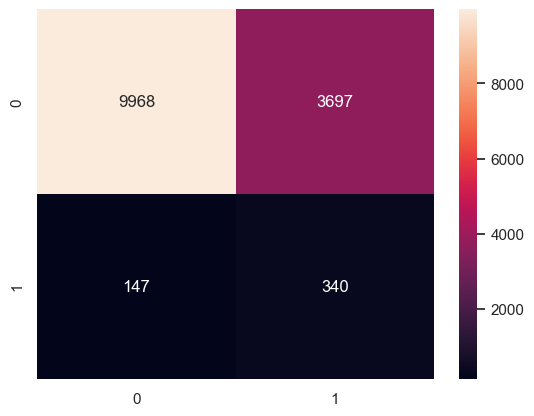

In [264]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='.0f')